In [1]:
import os 
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import json

In [2]:
weights = json.load(open('../Downloads/out_weights.json'))

In [3]:
#sc_out = pd.DataFrame()
#for file in os.listdir('../ce_data/StatCache'):
#    x = pd.read_csv("../ce_data/StatCache/"+file)
#    x['id'] = x.index
#    x['id'] = x['id'].apply(lambda x: file[:-4] + "_" + str(x))
#    sc_out = pd.concat([x, sc_out], ignore_index=True)
#sc_out = sc_out.sort_values("id", ascending=True, ignore_index=True).fillna(0)
sc_out = pd.read_csv('../ce_data/output_512/statcache_512_test.csv')
for i in ['1024','2048','4096','8192']:
    sc_out['lru_'+i] = sc_out['lru_'+i]/sc_out['total_accesses']
sc_out['lru_512'] = sc_out['lru_512']/sc_out['total_accesses_512']
print(sc_out)

                         id  random_512   lru_512  total_accesses_512  \
0       400.perlbench-41B_0    0.001717  0.001518           239494416   
1     400.perlbench-41B_436    0.006111  0.005379            80637776   
2       400.perlbench-50B_0    0.001107  0.000917           287013392   
3          401.bzip2-226B_0    0.020634  0.017885            27572144   
4         401.bzip2-226B_54    0.031862  0.025652            14841776   
...                     ...         ...       ...                 ...   
6186     657.xz_s-3167B_466    0.012274  0.010419            40672032   
6187     657.xz_s-3167B_574    0.011847  0.009570            42881744   
6188       657.xz_s-4994B_0    0.002144  0.001862           106624656   
6189     657.xz_s-4994B_343    0.004219  0.003779            81735968   
6190         657.xz_s-56B_0    0.000000  0.000000            92201088   

      random_1024  lru_1024  random_2048  lru_2048  random_4096  lru_4096  \
0        0.001534  0.001461     0.001290  0.00

In [4]:
cache_misses = pd.read_csv("../ce_data/output_512/dataset.csv")
for i in ['1024', '2048', '4096', '8192']:
    cache_misses[i] = cache_misses['misses_'+i] / cache_misses['accesses_'+i]
print(cache_misses, sc_out)

                         id         0         1         2        3        4  \
0       400.perlbench-41B_0  50816880  17323312  11868112  7701840  3853504   
1     400.perlbench-41B_436  17361520   6023600   4203744  2591488  1828656   
2       400.perlbench-50B_0  58283520  17249296  14592592  9466576  7204896   
3          401.bzip2-226B_0   3098304   3037808   2698720  2692176  1999568   
4         401.bzip2-226B_54   1623056   1618144   1501200  1353728  1014736   
...                     ...       ...       ...       ...      ...      ...   
6186     657.xz_s-3167B_466   4869744   5968224   3301024  2821488  2218352   
6187     657.xz_s-3167B_574   4967104   7056944   3530208  2928336  2367040   
6188       657.xz_s-4994B_0  18063488  19199008   9437200  7269680  7833904   
6189     657.xz_s-4994B_343  13498912  14343616   6633152  5098416  6450640   
6190         657.xz_s-56B_0  26356736  36838224  10074240  2059088  2506384   

            5        6        7        8  ...  acce

In [5]:
# Little check
d = {}
for i,j in zip(cache_misses["id"], sc_out["id"]):
    if i != j:
        print(i,j)
    if i in d: 
        print(i)
    d[i]=1

In [6]:
from sklearn.metrics import mean_squared_error
bdf = pd.DataFrame()
for i in ['1024', '2048', '4096', '8192']:
    tmp = sc_out['lru_'+i] / sc_out['lru_512']
    # This drops na
    cms = cache_misses[tmp <= 1]
    tmp = tmp[tmp <= 1]
    c_acc_lru = mean_squared_error(tmp, cms[i])
    #c_acc_rand = mean_squared_error(o['random_'+i], cache_misses[i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}')
    bdf['sc_'+i] = tmp
    bdf['cm_'+i] = cms[i]
    bdf['id'] = cms['id']
    bdf['diffs_'+i] = abs(tmp - cms[i])
    bdf['ndiffs_'+i] = (tmp - cms[i])

Cache size 1024	: lru_mse = 0.040659927533189165
Cache size 2048	: lru_mse = 0.08320138052142027
Cache size 4096	: lru_mse = 0.09476700899883736
Cache size 8192	: lru_mse = 0.08828091915279059


In [7]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error
#for i in ['1024','2048','4096','8192']:
#    tmp = sc_out['lru_'+i] * cache_misses['l1d_accesses_'+i]/cache_misses['accesses_'+i]
#    c_acc_lru = mean_squared_error(tmp, cache_misses[i])
#    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}')

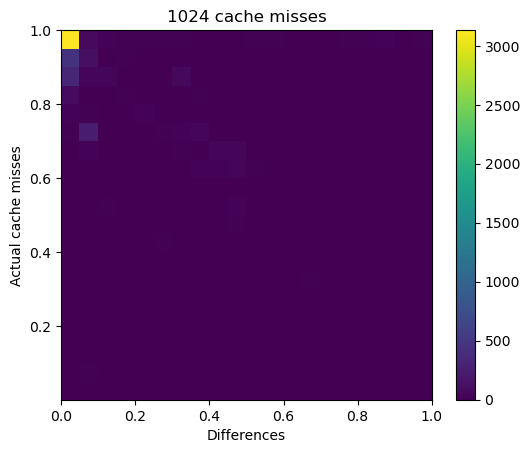

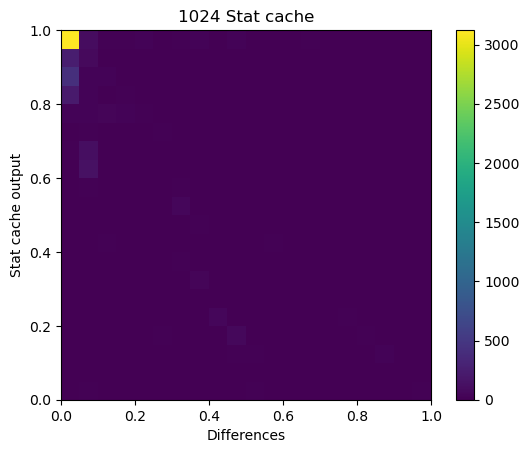

In [8]:
heatmap, xedges, yedges = np.histogram2d(bdf['diffs_1024'], bdf['cm_1024'], bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.title('1024 cache misses')
plt.xlabel('Differences')
plt.ylabel('Actual cache misses')
plt.show()
heatmap, xedges, yedges = np.histogram2d(bdf['diffs_1024'],  bdf['sc_1024'], bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.title('1024 Stat cache')
plt.ylabel('Stat cache output')
plt.xlabel('Differences')
plt.show()

<ipython-input-9-c4916e6725c8>:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "block" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'../Documents/nn_figures/statcache_heats_{i}.png', block=False)


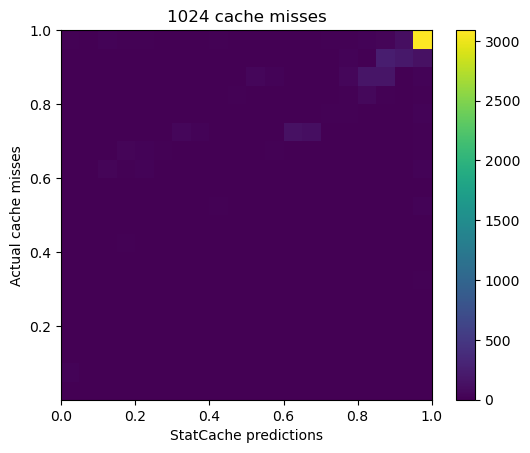

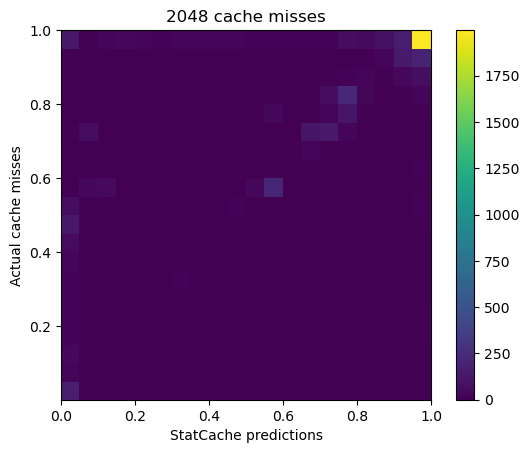

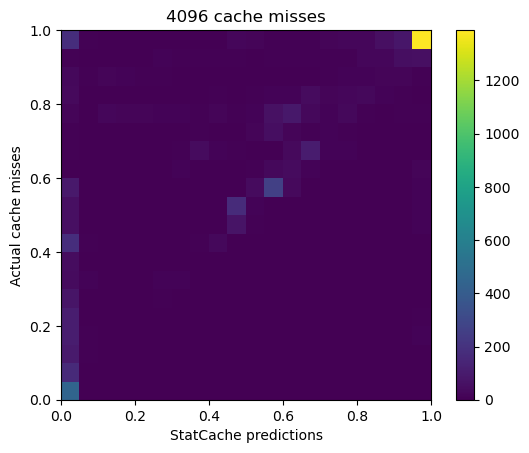

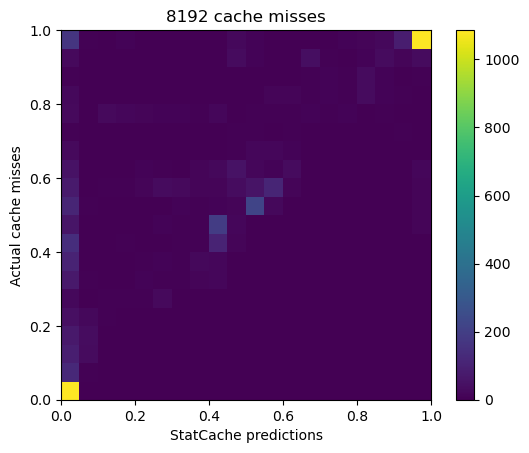

In [9]:
def plot_bdf(bdf):
    for i in ['1024','2048','4096','8192']:
#         print(mean_squared_error(bdf['cm_'+i], bdf['sc_'+i]))
        heatmap, xedges, yedges = np.histogram2d(bdf['sc_'+i], bdf['cm_'+i], bins=20)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        plt.clf()
        plt.imshow(heatmap.T, extent=extent, origin='lower')
        plt.colorbar()
        plt.title(i+' cache misses')
        plt.xlabel('StatCache predictions')
        plt.ylabel('Actual cache misses')
        plt.savefig(f'../Documents/nn_figures/statcache_heats_{i}.png', block=False)
        plt.show()
plot_bdf(bdf)

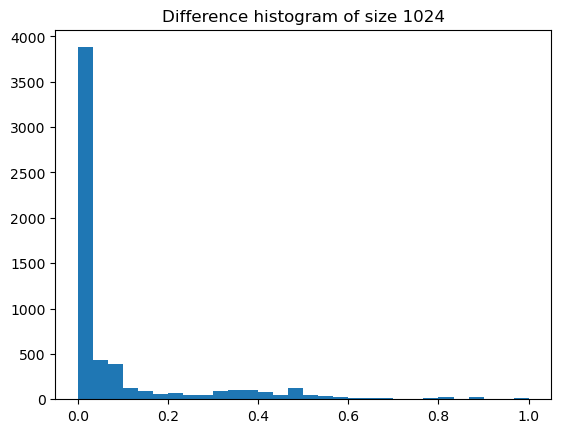

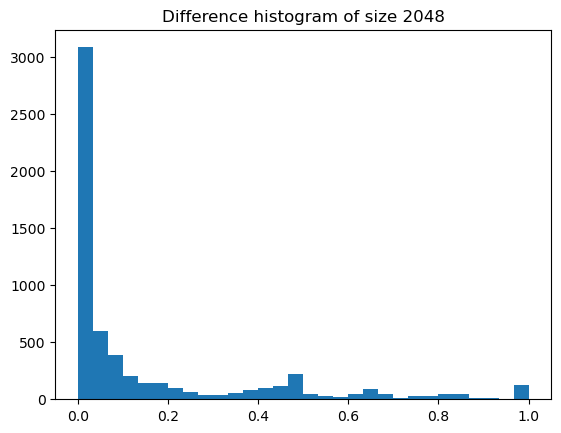

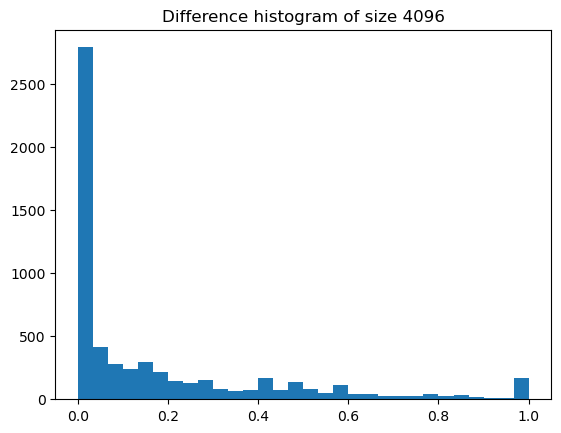

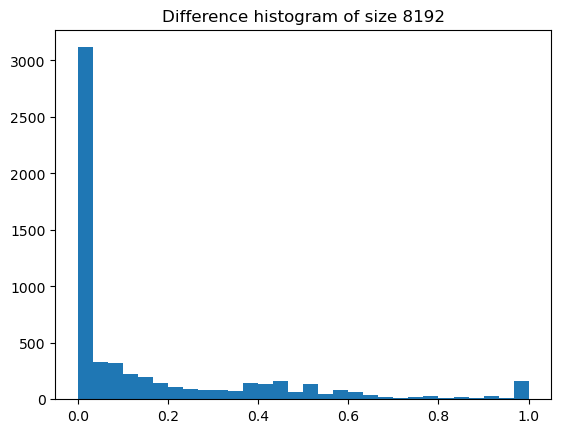

In [10]:
for i in ['1024','2048','4096','8192']:
    plt.title(f"Difference histogram of size {i}")
    plt.hist(bdf['diffs_'+i], bins =30)
    plt.show()

In [11]:
d = {}
for i in sc_out["id"]:
    ctr = 1
    while(1):
        if i[-ctr] == '_':
            break
        ctr+=1
    d[i[:-ctr]] = 1

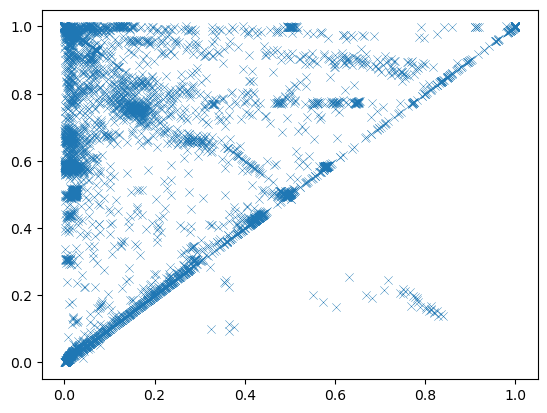

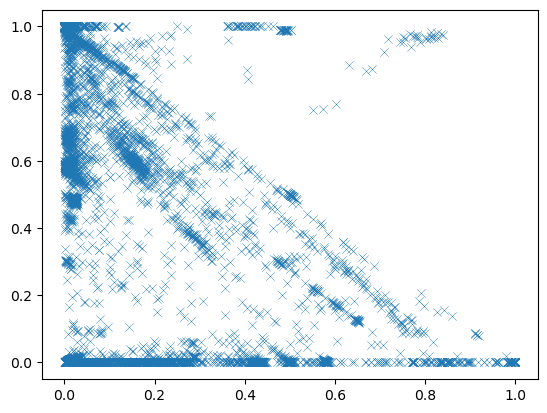

In [12]:
c = '4096'
plt.scatter(bdf['diffs_'+c], bdf['cm_'+c], marker='x', linewidths = 0.3)
plt.show()
plt.scatter(bdf['diffs_'+c], bdf['sc_'+c], marker='x', linewidths = 0.3)
plt.show()

In [13]:
columns = ["id"]
for i in ['1024','2048','4096','8192']:
    columns.append('diffs_'+i)
for i in ['1024','2048','4096','8192']:
    columns.append('cm_'+i)
    columns.append('sc_'+i)

In [14]:
# Outputs sorted by difference for some data analysis
bdf.sort_values("diffs_"+c, ascending=False)[columns].head(10)

id  diffs_1024  diffs_2048  diffs_4096  \
107             403.gcc-16B_447    0.000000    0.211656    1.000000   
5767   649.fotonik3d_s-7084B_33    0.000002    0.000002    0.999998   
5772  649.fotonik3d_s-7084B_118    0.000000    0.000002    0.999998   
5796  649.fotonik3d_s-7084B_526    0.000002    0.000004    0.999996   
5799  649.fotonik3d_s-7084B_577    0.000004    0.000004    0.999996   
5776  649.fotonik3d_s-7084B_186    0.000004    0.000005    0.999995   
5775  649.fotonik3d_s-7084B_169    0.000002    0.000004    0.999995   
5797  649.fotonik3d_s-7084B_543    0.000004    0.000005    0.999995   
5789  649.fotonik3d_s-7084B_407    0.000005    0.000009    0.999993   
5780  649.fotonik3d_s-7084B_254    0.000005    0.000005    0.999993   

      diffs_8192   cm_1024  sc_1024   cm_2048   sc_2048   cm_4096  sc_4096  \
107     0.999987  1.000000      1.0  1.000000  0.788344  1.000000      0.0   
5767    0.999862  0.999998      1.0  0.999998  1.000000  0.999998      0.0   
5772    0.999995  1.000000      1.0  0.999998  1.000000  0.999998      0.0   
5796    0.999953  0.999998      1.0  0.999996  1.000000  0.999996      0.0   
5799    0.999811  0.999996      1.0  0.999996  1.000000  0.999996      0.0   
5776    0.999962  0.999996      1.0  0.999995  1.000000  0.999995      0.0   
5775    0.999982  0.999998      1.0  0.999996  1.000000  0.999995      0.0   
5797    0.999883  0.999996      1.0  0.999995  1.000000  0.999995      0.0   
5789    0.999930  0.999995      1.0  0.999991  1.000000  0.999993      0.0   
5780    0.999969  0.999995      1.0  0.999995  1.000000  0.999993      0.0   

       cm_8192  sc_8192  
107   0.999987      0.0  
5767  0.999862      0.0  
5772  0.999995      0.0  
5796  0.999953      0.0  
5799  0.999811      0.0  
5776  0.999962      0.0  
5775  0.999982      0.0  
5797  0.999883      0.0  
5789  0.999930      0.0  
5780  0.999969      0.0

In [15]:
name_list_4096 = ['GemsFDTD']
l = [bool(sum(j in i for j in name_list_4096)) for i in bdf["id"]]
bdf_4096 = bdf[l]

<ipython-input-9-c4916e6725c8>:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "block" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'../Documents/nn_figures/statcache_heats_{i}.png', block=False)


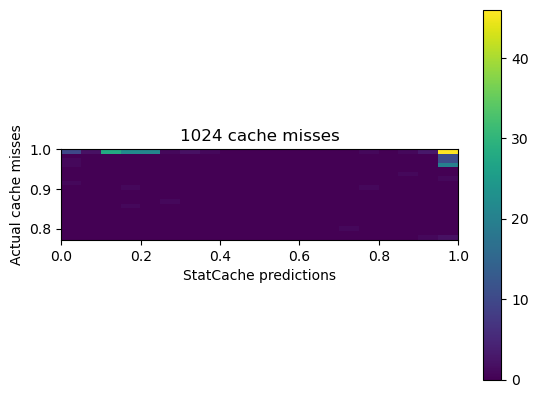

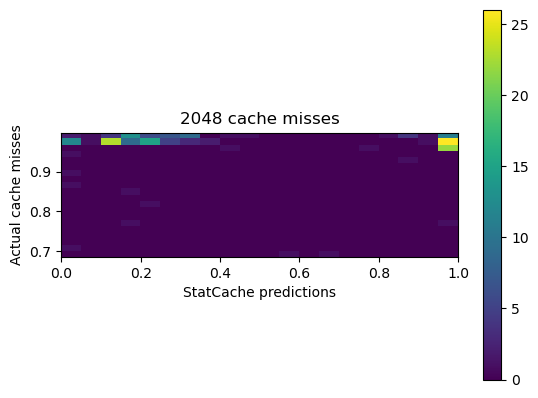

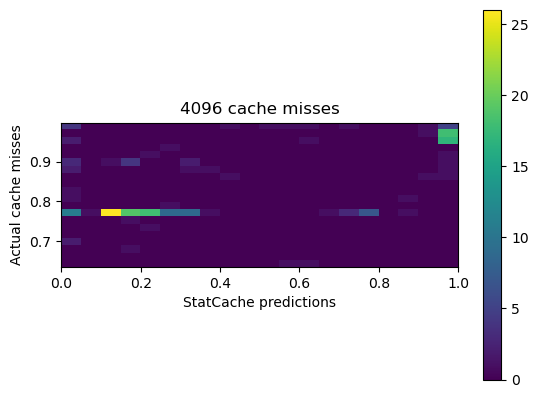

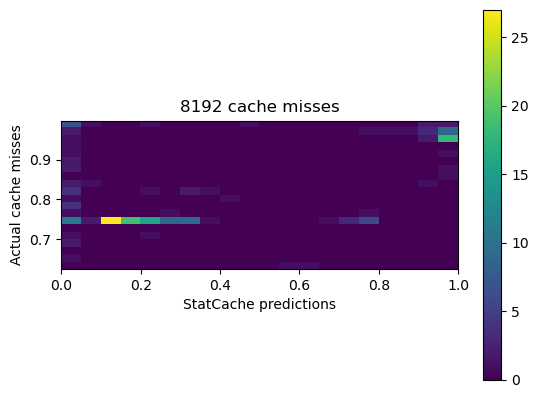

In [16]:
plot_bdf(bdf_4096)

In [17]:
bdf_4096.sort_values("diffs_1024", ascending=False)

sc_1024  cm_1024                      id  diffs_1024  ndiffs_1024  \
1791      0.0      1.0   459.GemsFDTD-1491B_21         1.0         -1.0   
1790      0.0      1.0   459.GemsFDTD-1491B_10         1.0         -1.0   
1793      0.0      1.0   459.GemsFDTD-1491B_43         1.0         -1.0   
1794      0.0      1.0   459.GemsFDTD-1491B_54         1.0         -1.0   
1795      0.0      1.0   459.GemsFDTD-1491B_65         1.0         -1.0   
...       ...      ...                     ...         ...          ...   
1819      1.0      1.0  459.GemsFDTD-1491B_724         0.0          0.0   
1818      1.0      1.0  459.GemsFDTD-1491B_712         0.0          0.0   
1817      1.0      1.0  459.GemsFDTD-1491B_700         0.0          0.0   
1816      1.0      1.0  459.GemsFDTD-1491B_688         0.0          0.0   
1755      1.0      1.0  459.GemsFDTD-1320B_714         0.0          0.0   

       sc_2048   cm_2048  diffs_2048  ndiffs_2048   sc_4096   cm_4096  \
1791  0.000000  0.979655    0.979655    -0.979655  0.000000  0.772663   
1790  0.000000  0.981309    0.981309    -0.981309  0.000000  0.770218   
1793  0.000000  0.981478    0.981478    -0.981478  0.000000  0.774982   
1794  0.000000  0.978902    0.978902    -0.978902  0.000000  0.772827   
1795  0.000000  0.983027    0.983027    -0.983027  0.000000  0.770602   
...        ...       ...         ...          ...       ...       ...   
1819  1.000000  0.979665    0.020335     0.020335  0.676883  0.774192   
1818  0.300752  0.983400    0.682647    -0.682647  0.300752  0.774073   
1817  0.300723  0.983388    0.682665    -0.682665  0.300723  0.772461   
1816  0.347354  0.982938    0.635583    -0.635583  0.347354  0.771007   
1755  1.000000  0.980542    0.019458     0.019458  0.747753  0.773789   

      diffs_4096  ndiffs_4096   sc_8192   cm_8192  diffs_8192  ndiffs_8192  
1791    0.772663    -0.772663  0.000000  0.750271    0.750271    -0.750271  
1790    0.770218    -0.770218  0.000000  0.750280    0.750280    -0.750280  
1793    0.774982    -0.774982  0.000000  0.750405    0.750405    -0.750405  
1794    0.772827    -0.772827  0.000000  0.750284    0.750284    -0.750284  
1795    0.770602    -0.770602  0.000000  0.750330    0.750330    -0.750330  
...          ...          ...       ...       ...         ...          ...  
1819    0.097310    -0.097310  0.676883  0.750115    0.073232    -0.073232  
1818    0.473321    -0.473321  0.300752  0.750114    0.449361    -0.449361  
1817    0.471737    -0.471737  0.300723  0.750135    0.449411    -0.449411  
1816    0.423652    -0.423652  0.335910  0.750114    0.414204    -0.414204  
1755    0.026036    -0.026036  0.747753  0.750285    0.002531    -0.002531  

[193 rows x 17 columns]

In [18]:
filenames = []
for i in bdf["id"]:
    nmb = i.split('_')[-1]
    filenames.append(i[:-len(nmb)-1])
bdf["file_name"] = filenames

In [19]:
np.linspace(0,1,21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

400.perlbench-41B


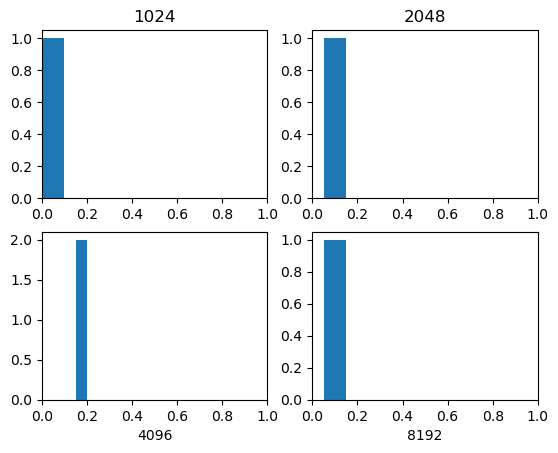

400.perlbench-50B


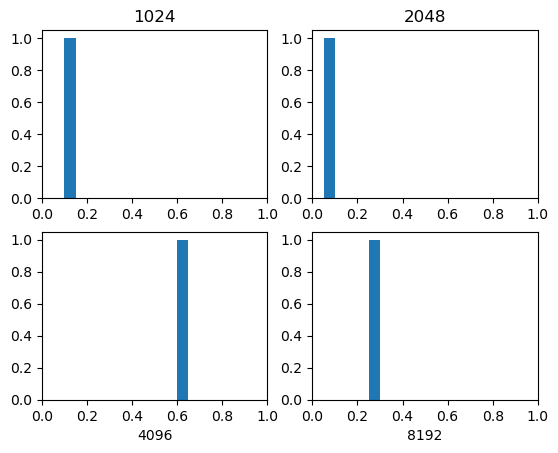

401.bzip2-226B


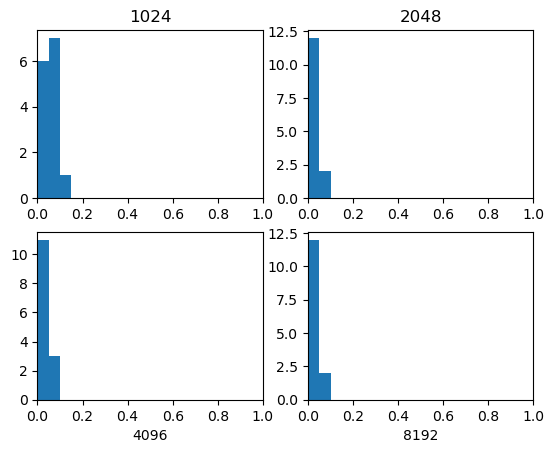

401.bzip2-277B


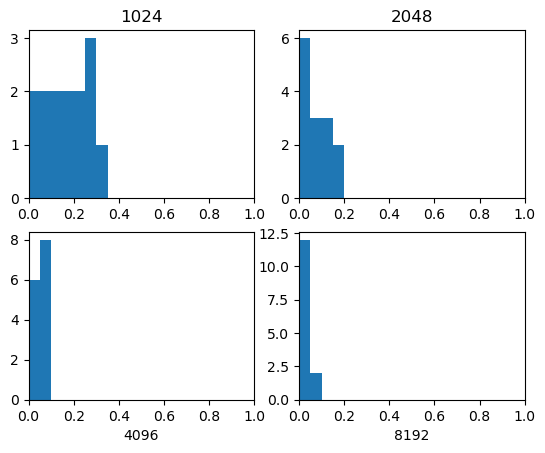

401.bzip2-38B


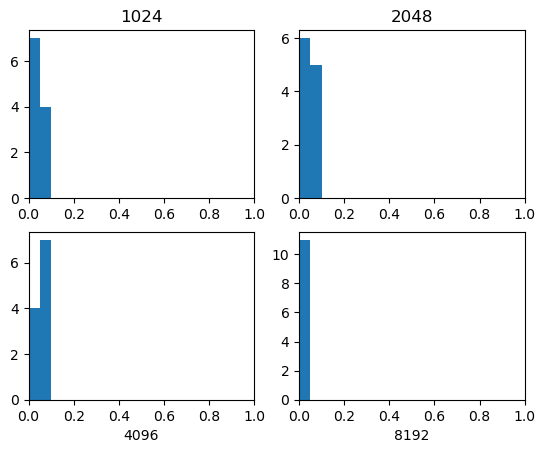

401.bzip2-7B


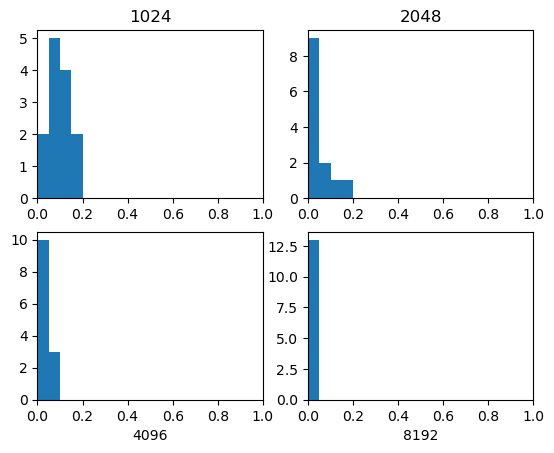

403.gcc-16B


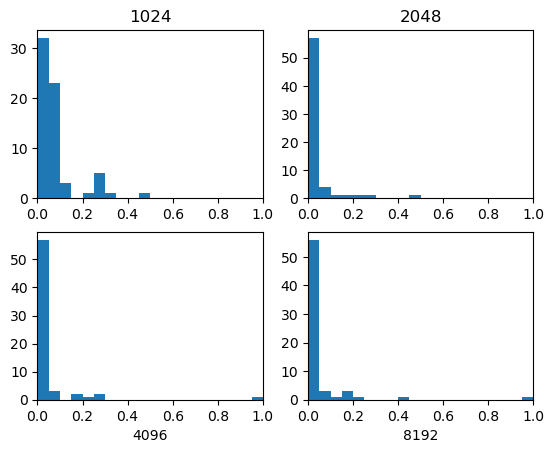

403.gcc-17B


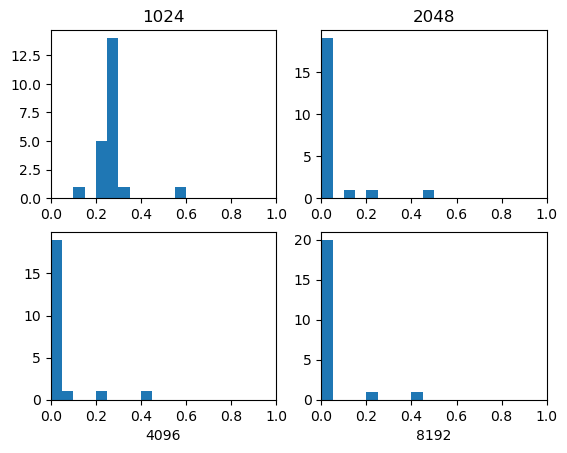

403.gcc-48B


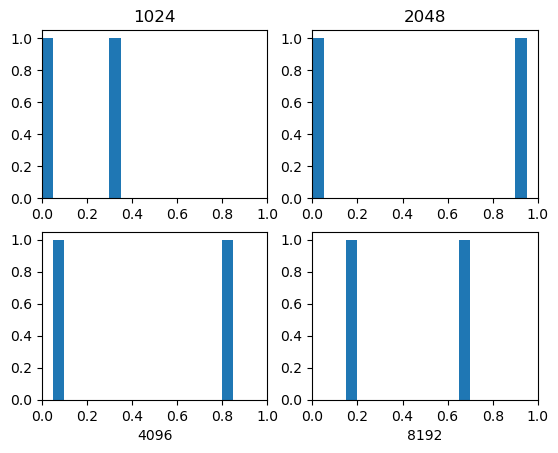

410.bwaves-1963B


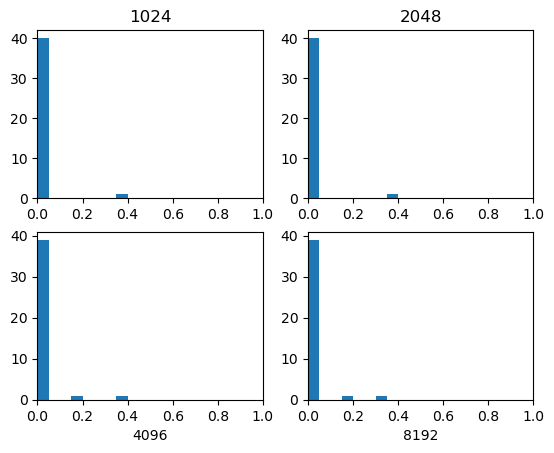

410.bwaves-2097B


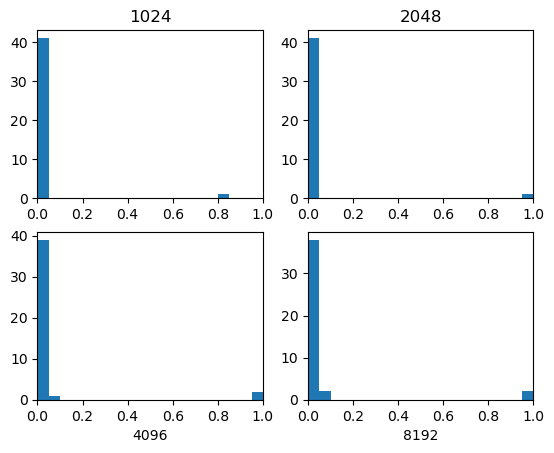

429.mcf-184B


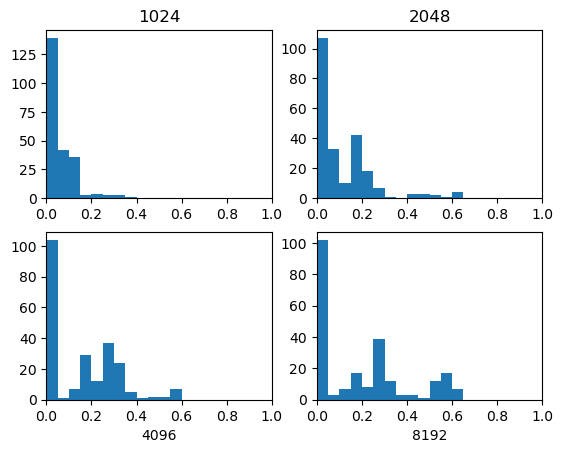

429.mcf-192B


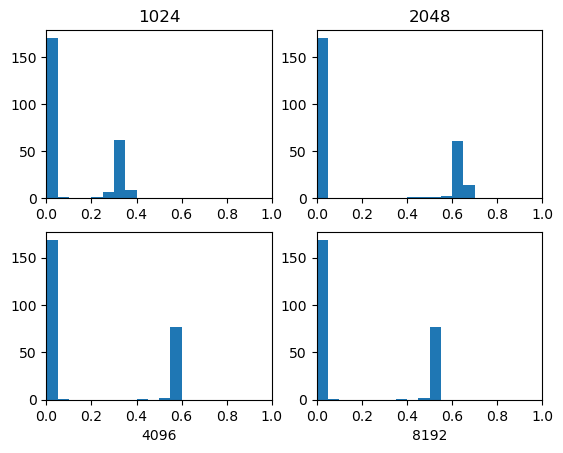

429.mcf-217B


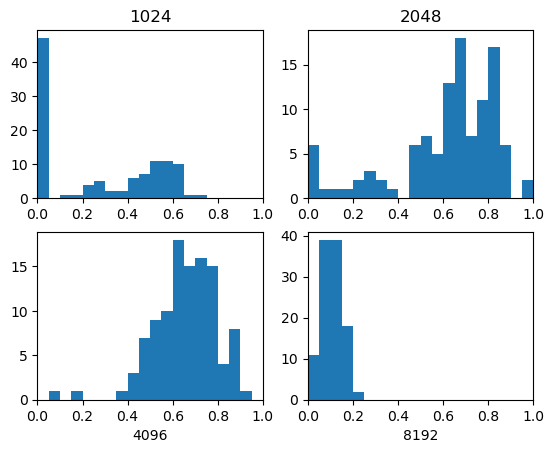

429.mcf-22B


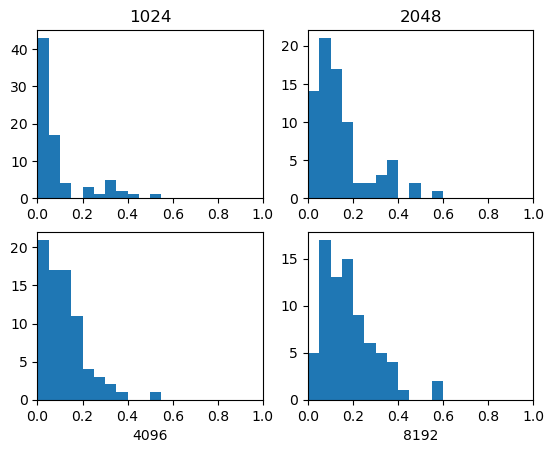

429.mcf-51B


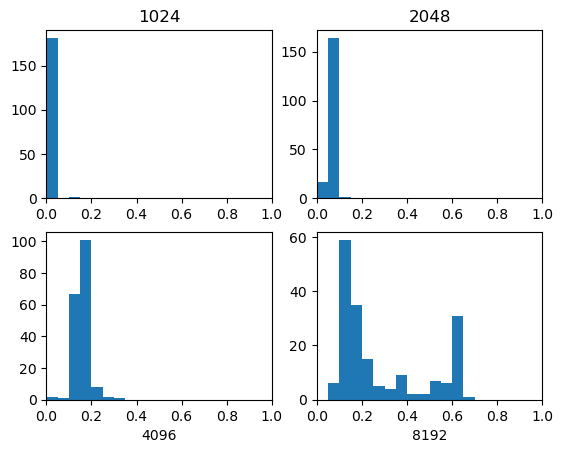

433.milc-127B


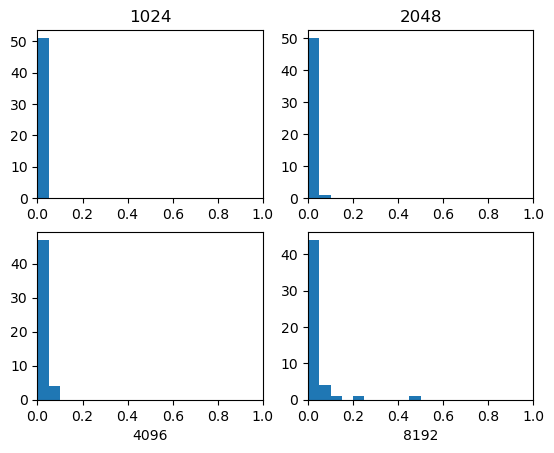

433.milc-274B


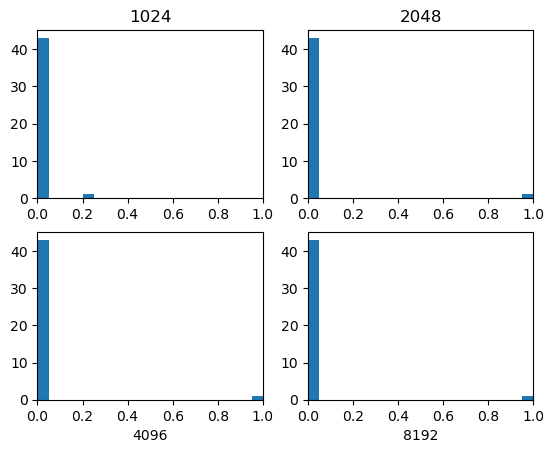

433.milc-337B


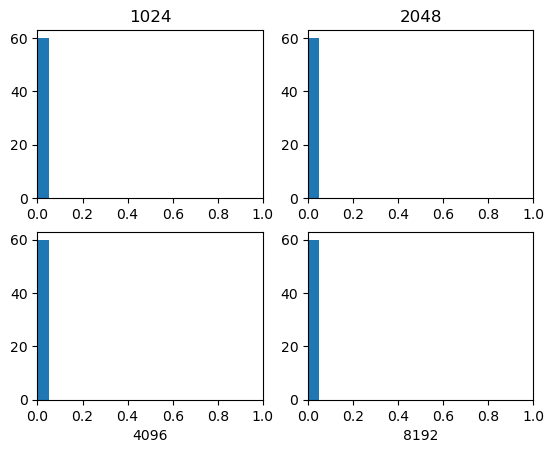

434.zeusmp-10B


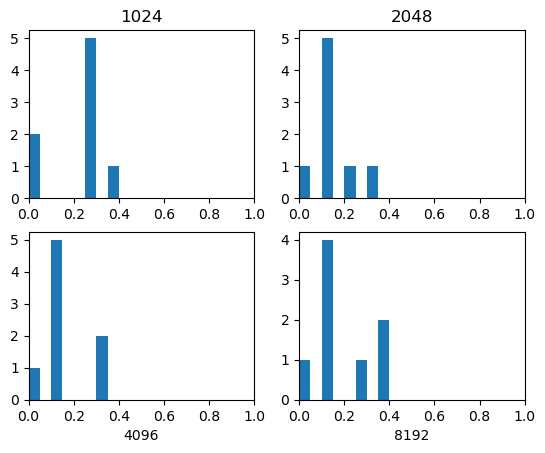

435.gromacs-111B


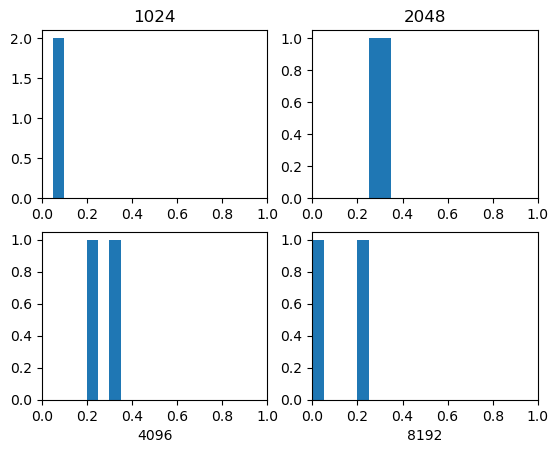

435.gromacs-134B


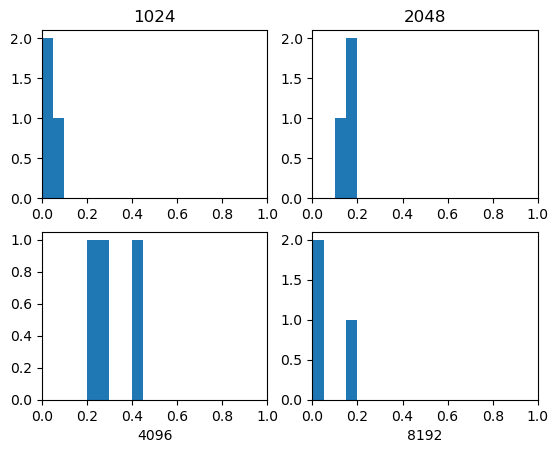

435.gromacs-226B


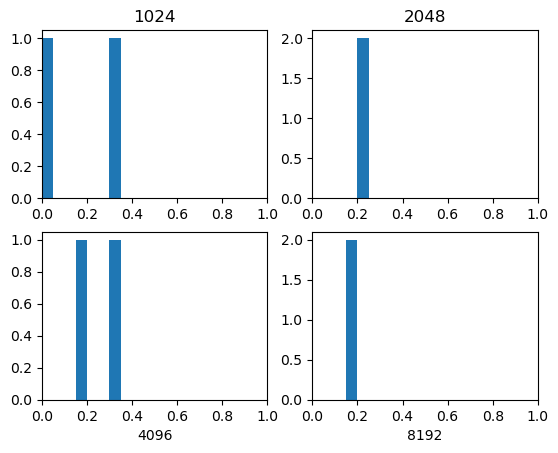

435.gromacs-228B


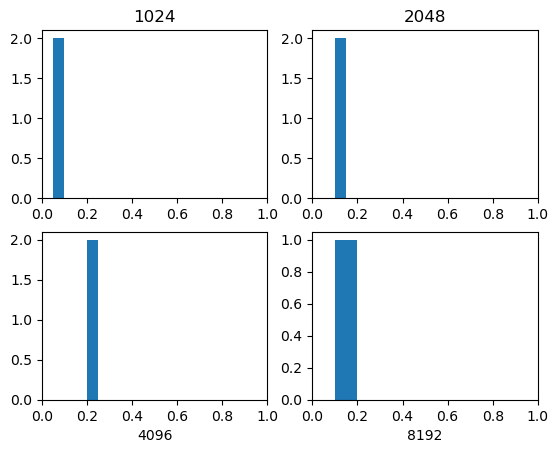

436.cactusADM-1804B


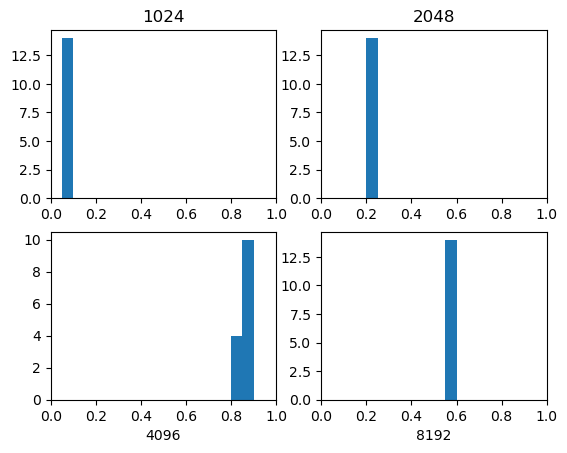

437.leslie3d-134B


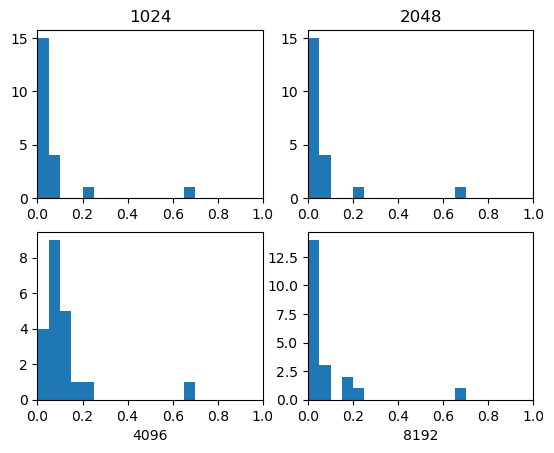

437.leslie3d-149B


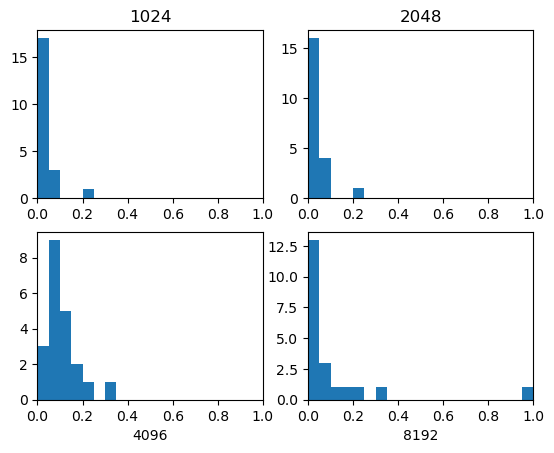

437.leslie3d-232B


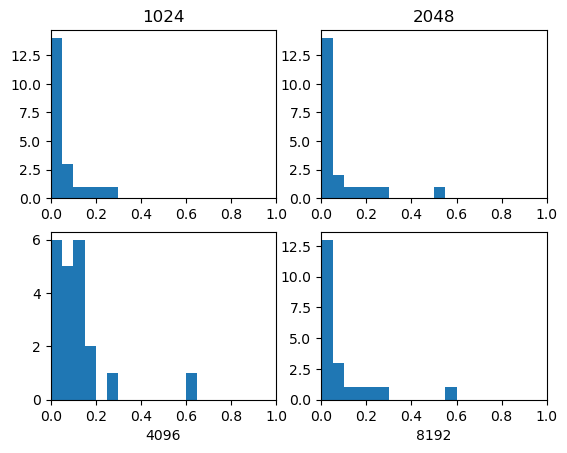

437.leslie3d-265B


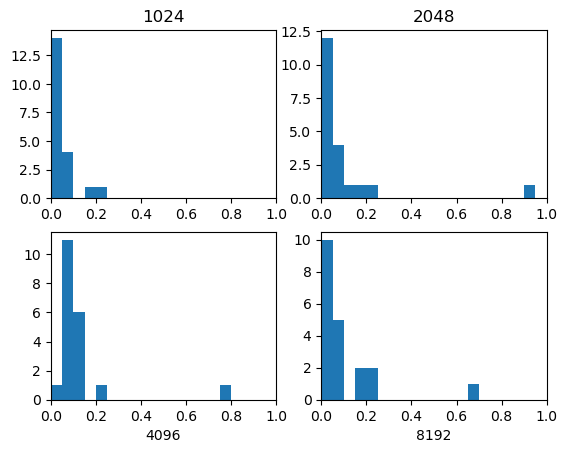

437.leslie3d-271B


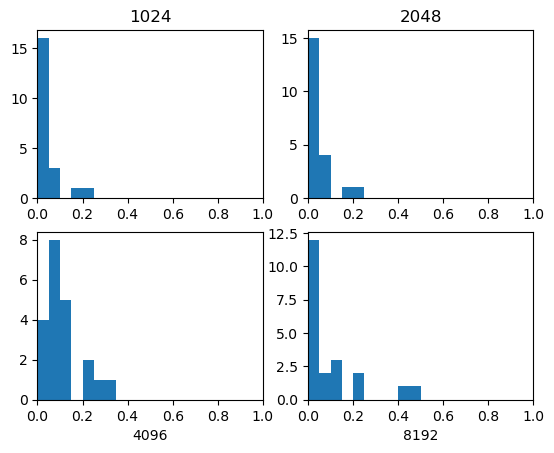

437.leslie3d-273B


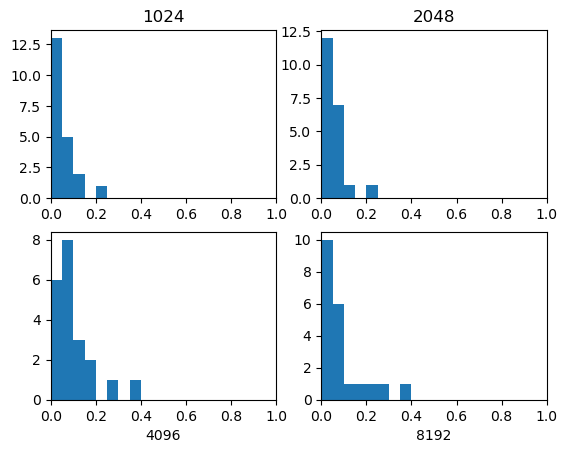

444.namd-120B


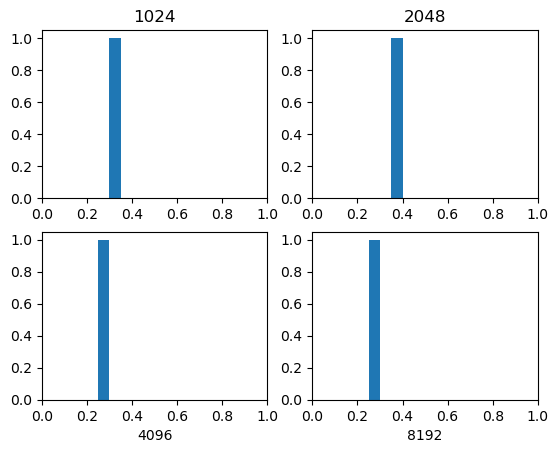

444.namd-166B


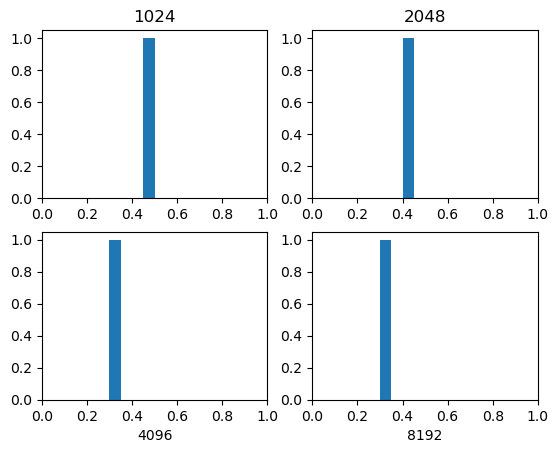

444.namd-23B


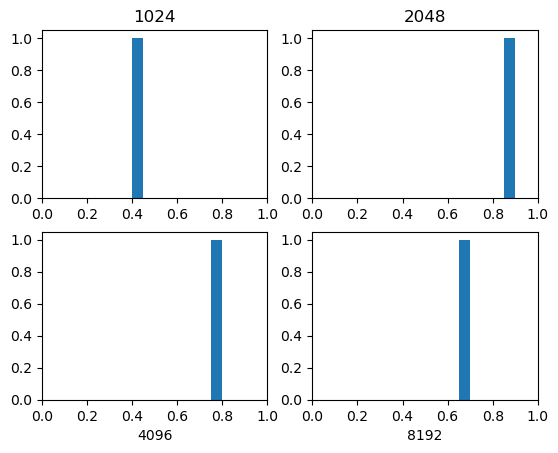

444.namd-321B


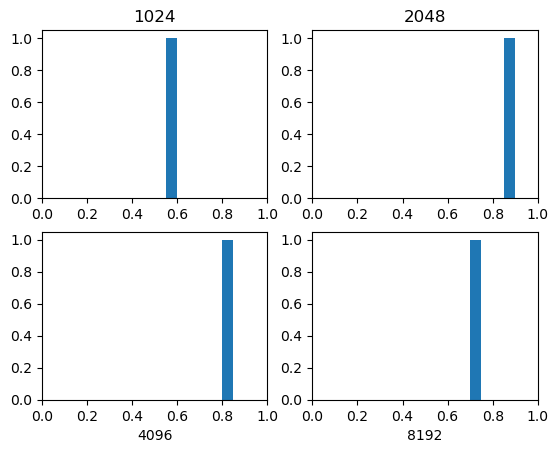

444.namd-33B


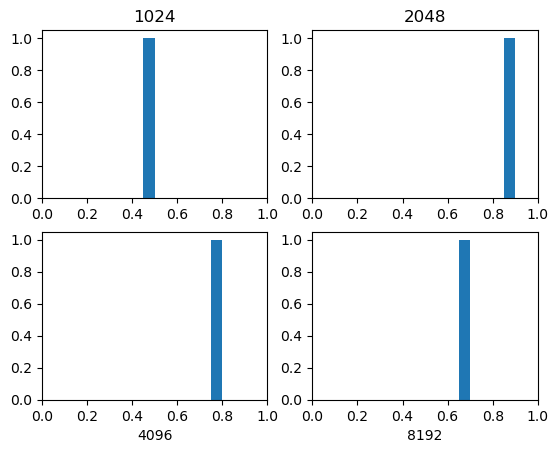

444.namd-426B


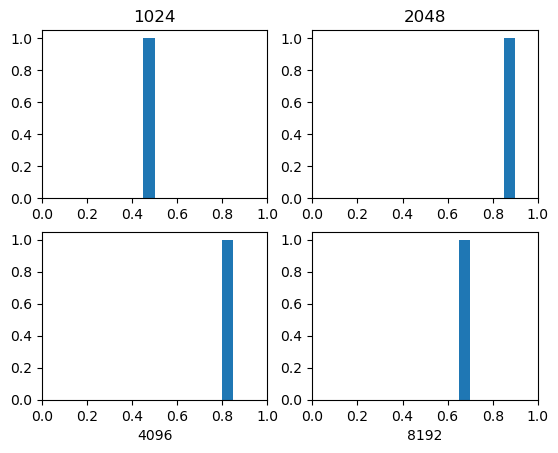

445.gobmk-17B


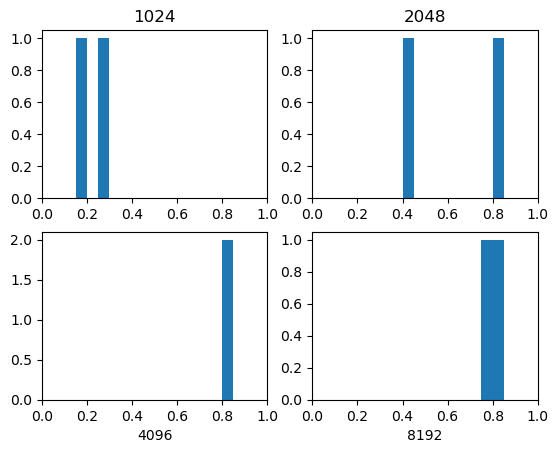

445.gobmk-2B


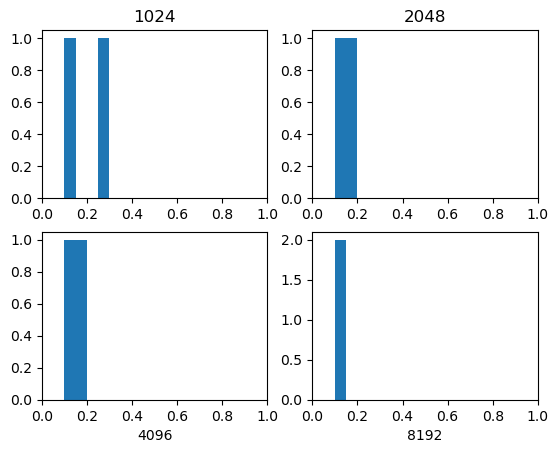

445.gobmk-30B


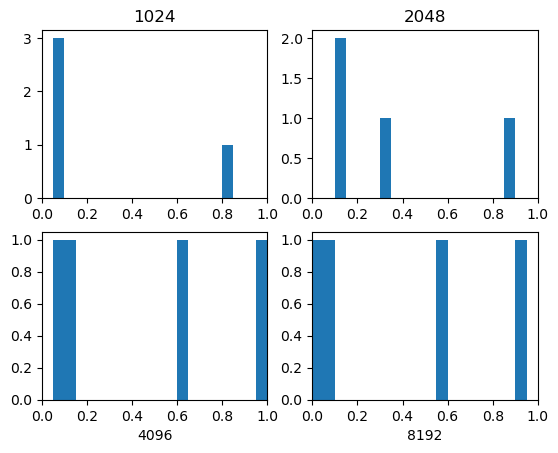

445.gobmk-36B


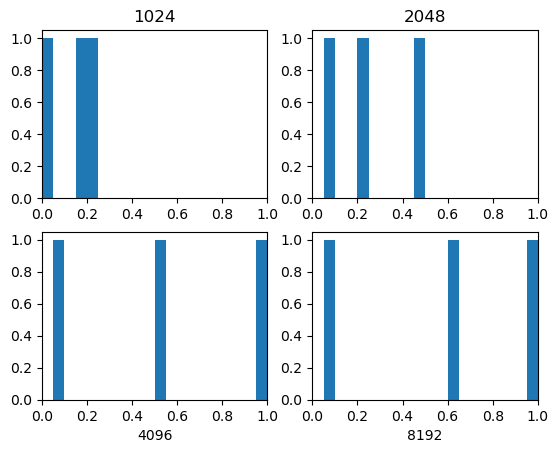

447.dealII-3B


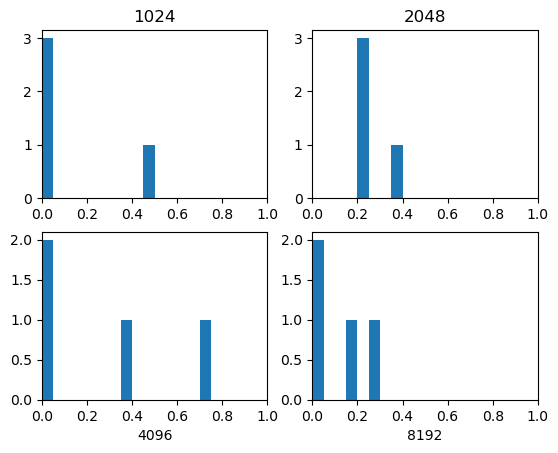

450.soplex-247B


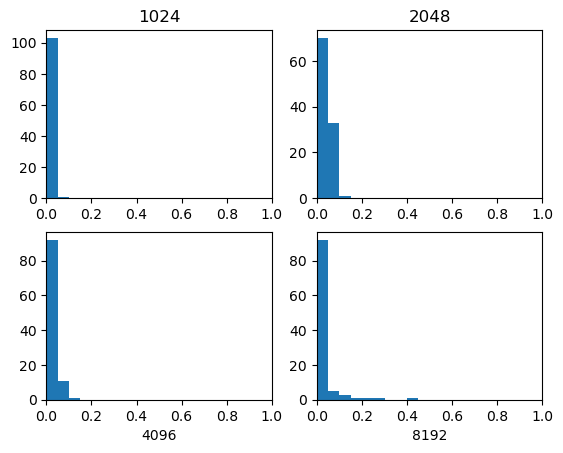

450.soplex-92B


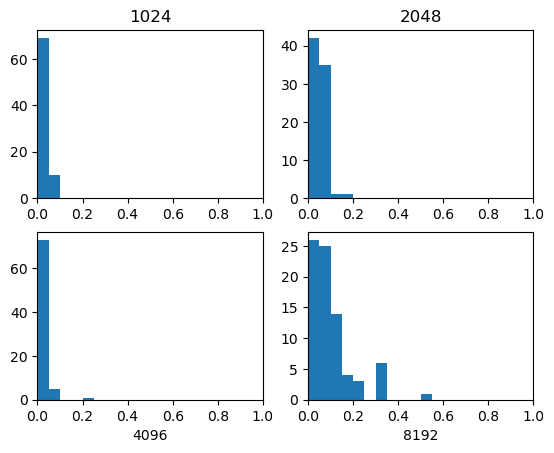

454.calculix-460B


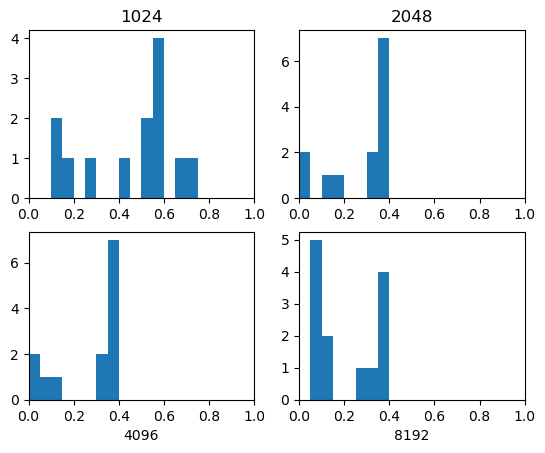

456.hmmer-191B


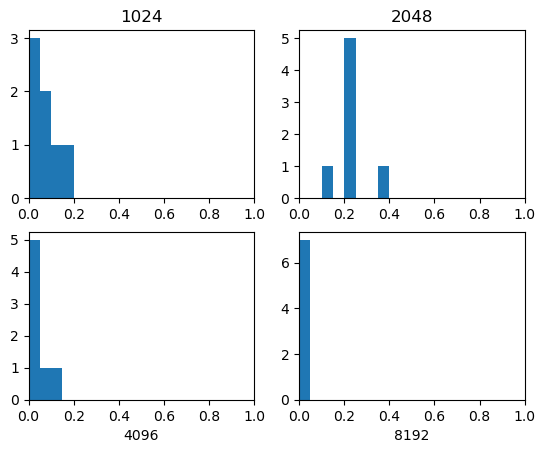

456.hmmer-327B


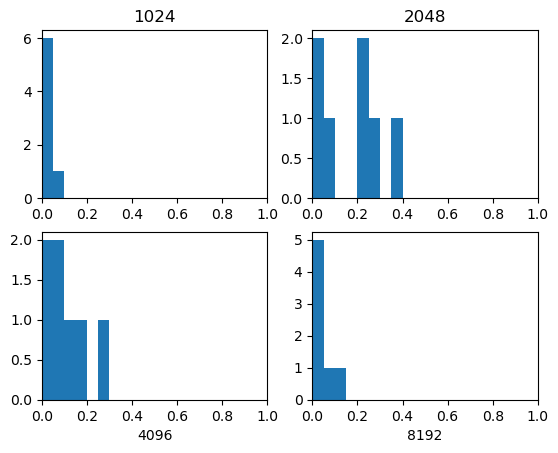

456.hmmer-88B


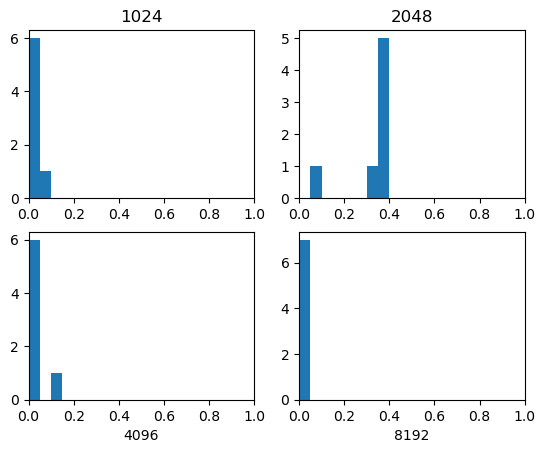

458.sjeng-1088B


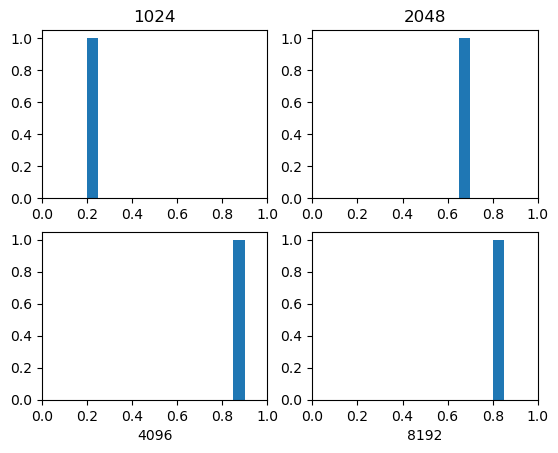

458.sjeng-283B


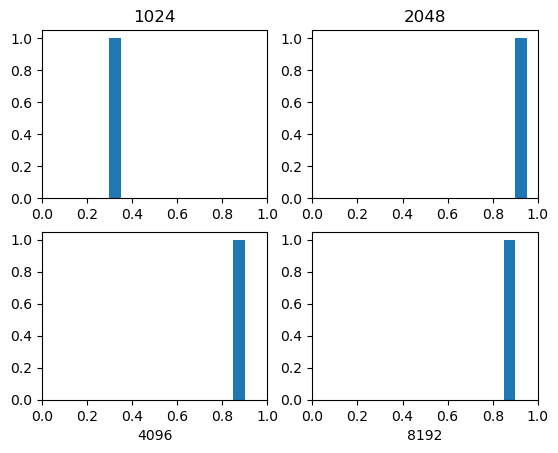

458.sjeng-31B


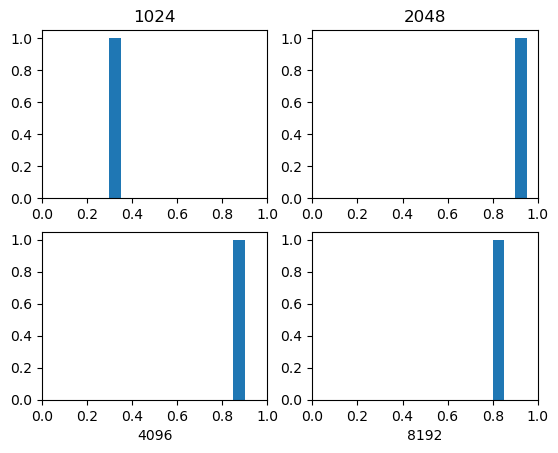

458.sjeng-767B


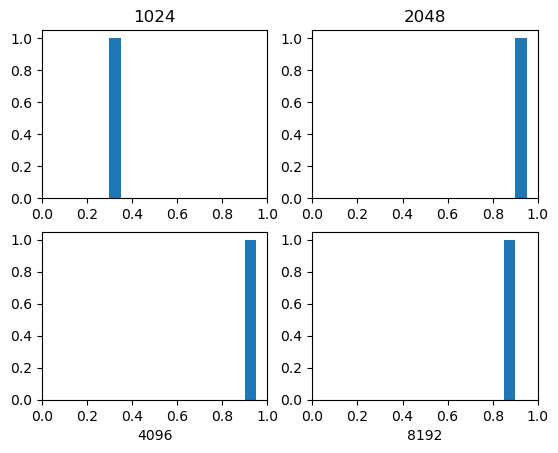

459.GemsFDTD-1169B


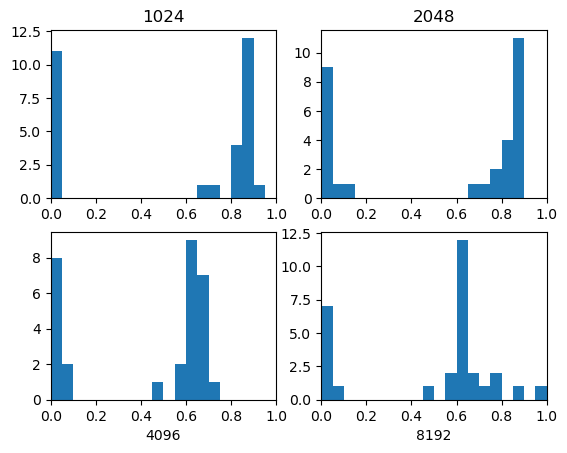

459.GemsFDTD-1211B


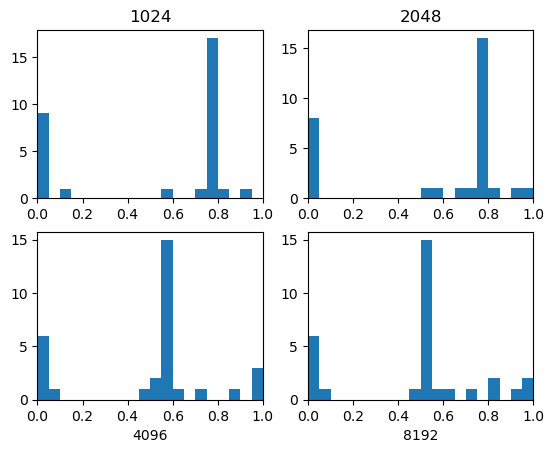

459.GemsFDTD-1320B


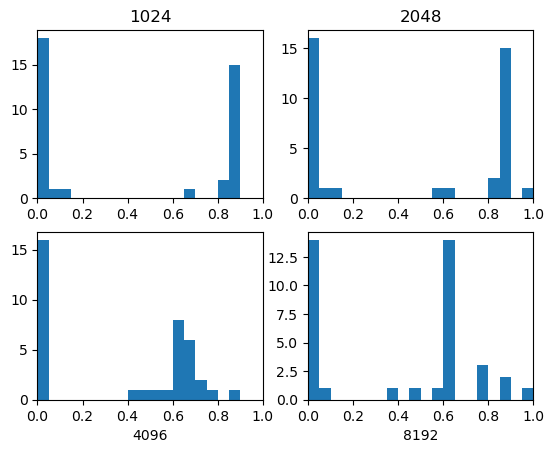

459.GemsFDTD-1418B


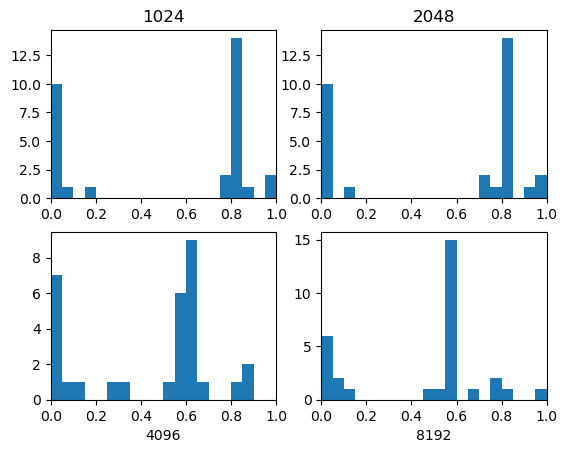

459.GemsFDTD-1491B


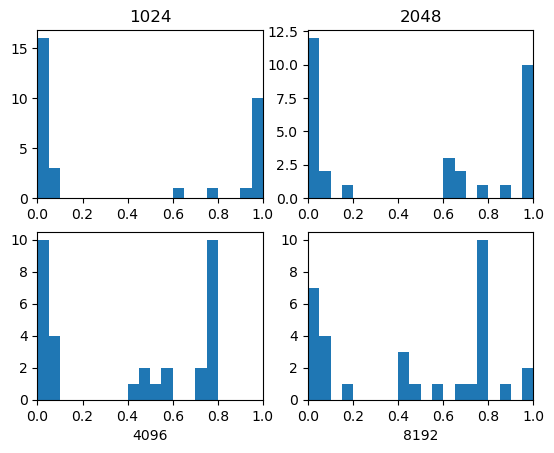

459.GemsFDTD-765B


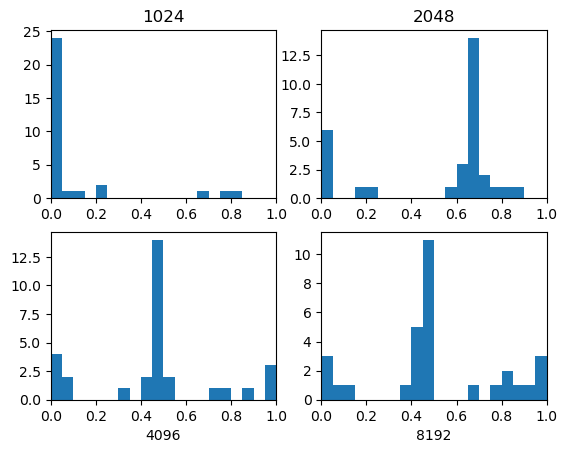

462.libquantum-1343B


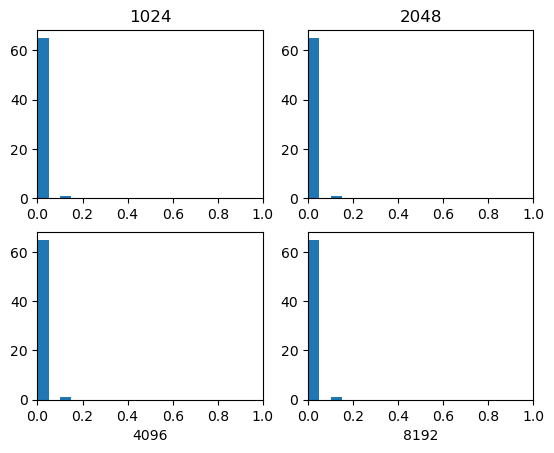

462.libquantum-714B


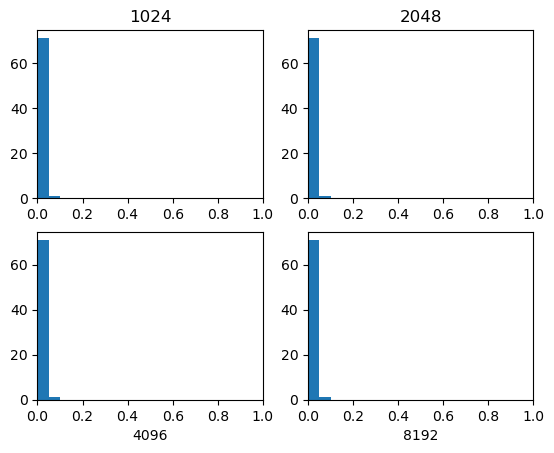

464.h264ref-30B


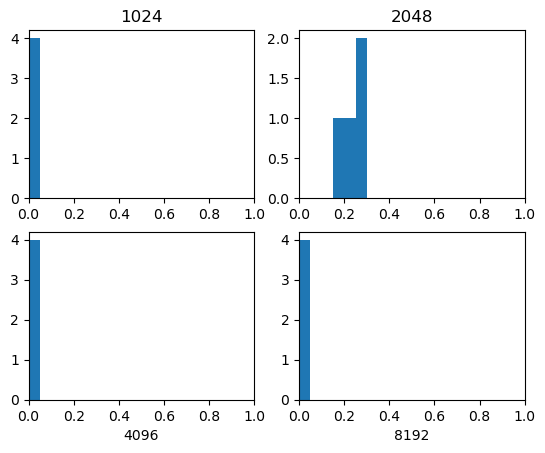

464.h264ref-57B


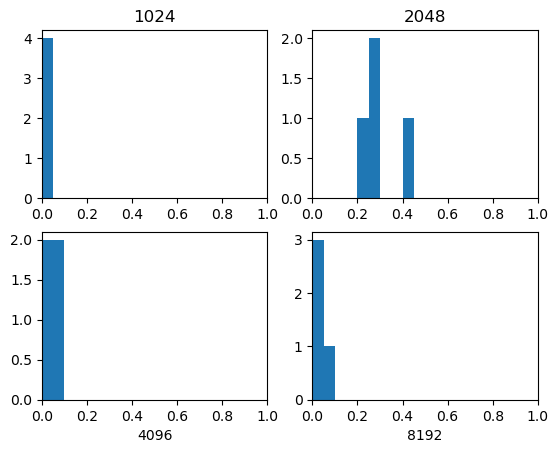

464.h264ref-64B


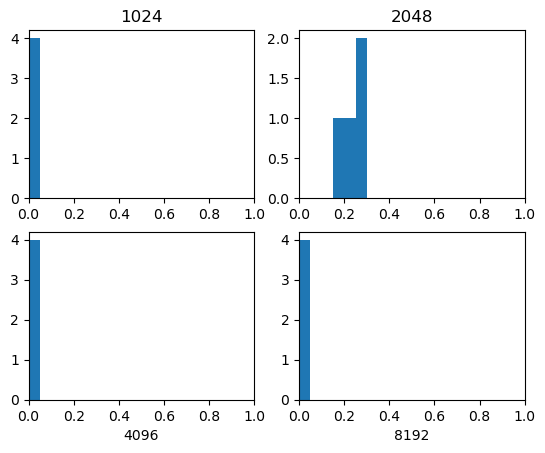

464.h264ref-97B


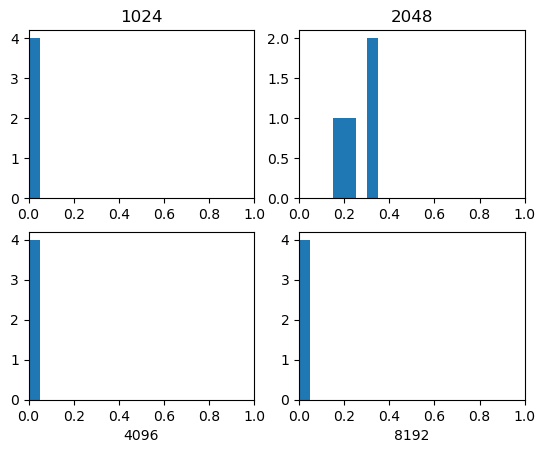

465.tonto-1914B


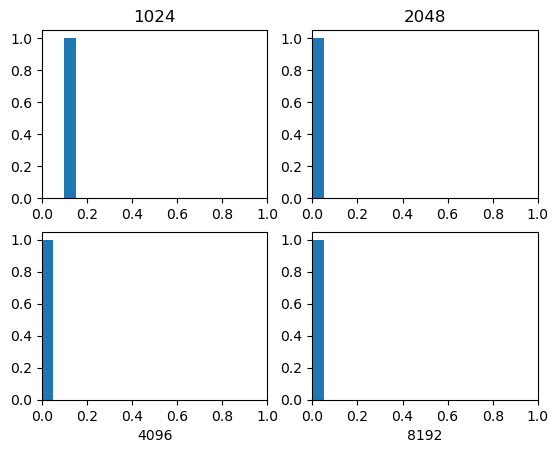

465.tonto-44B


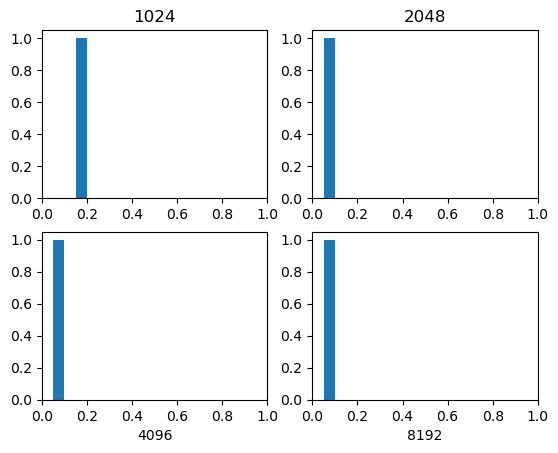

470.lbm-1274B


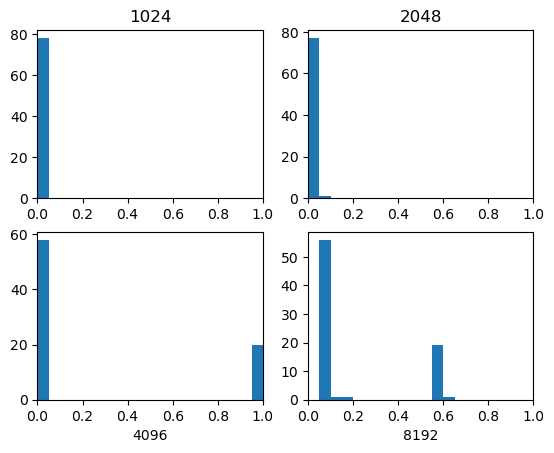

471.omnetpp-188B


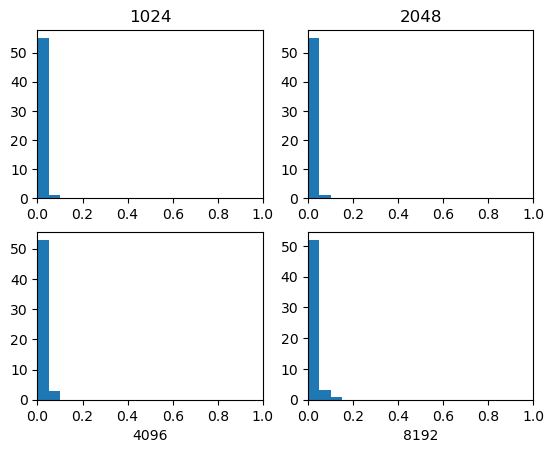

473.astar-153B


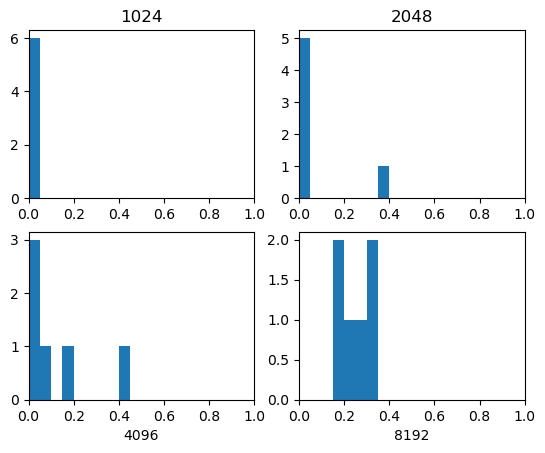

473.astar-359B


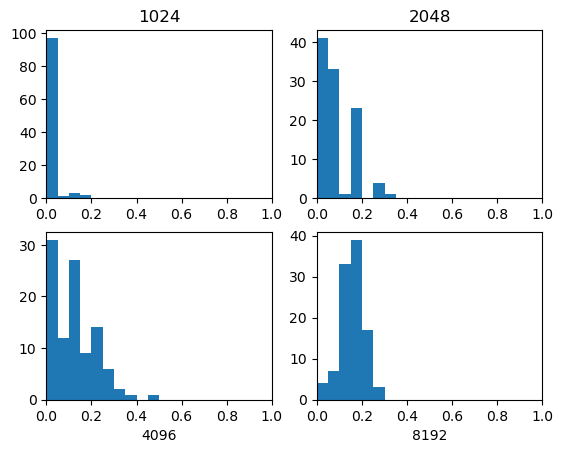

473.astar-42B


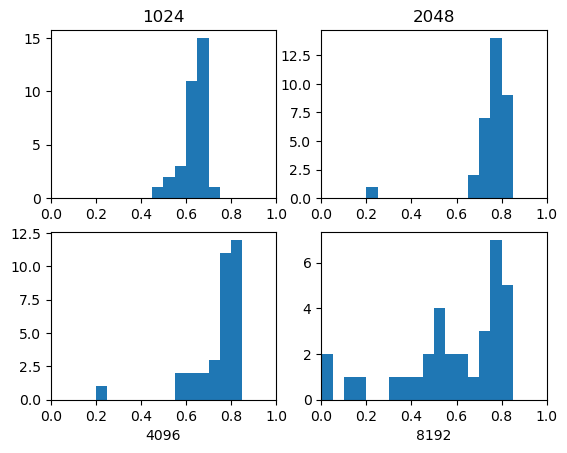

481.wrf-1170B


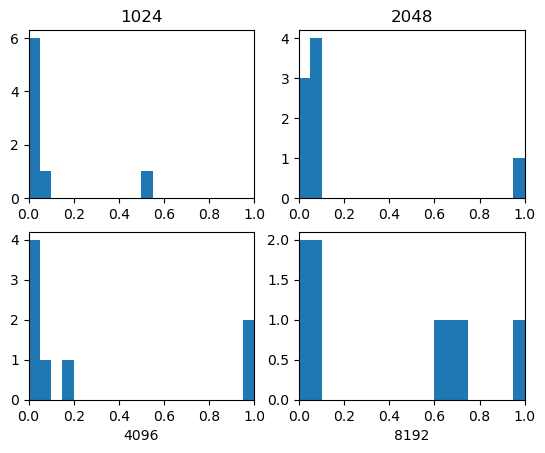

481.wrf-1254B


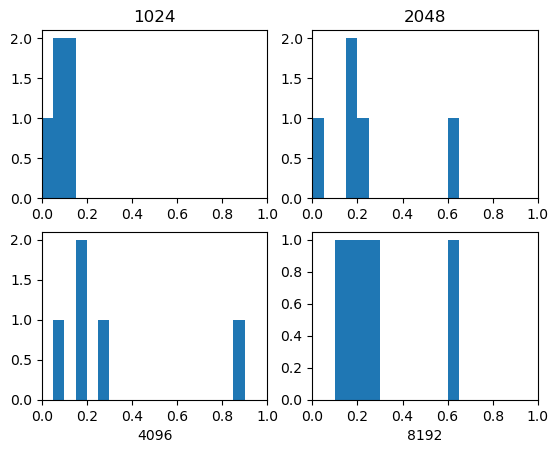

481.wrf-1281B


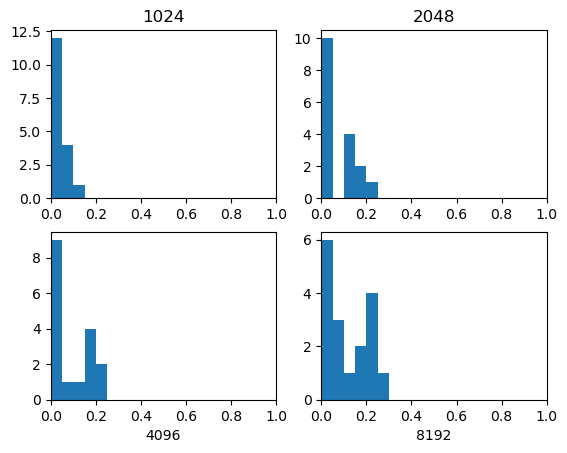

481.wrf-196B


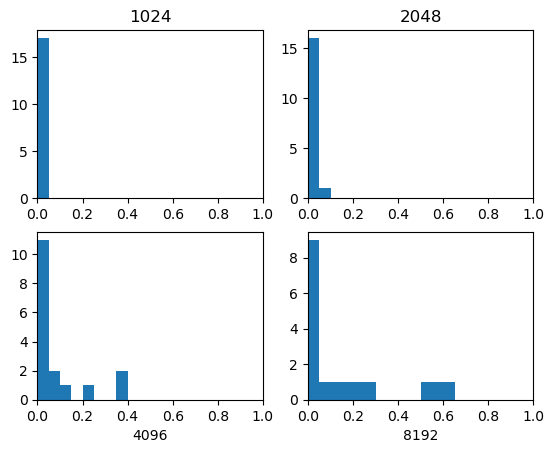

481.wrf-455B


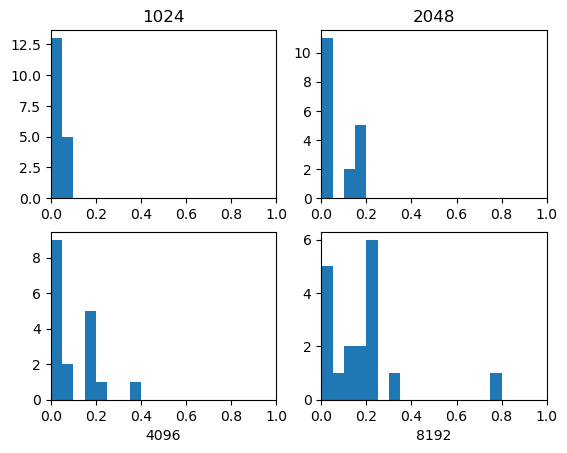

481.wrf-816B


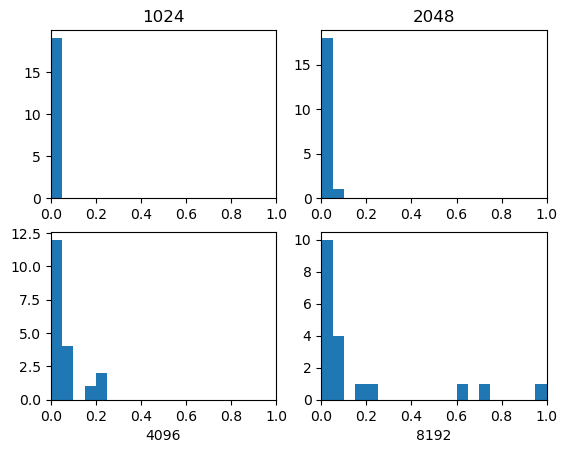

482.sphinx3-1100B


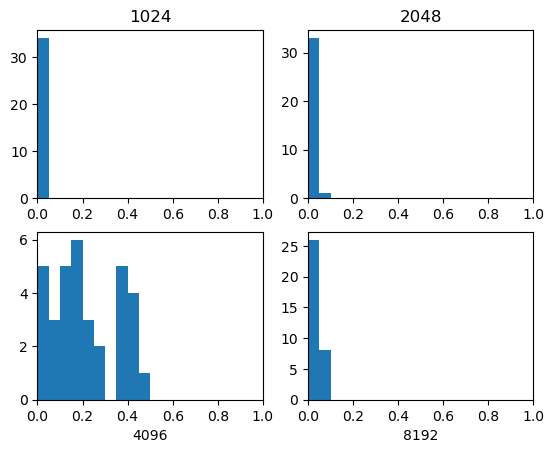

482.sphinx3-1297B


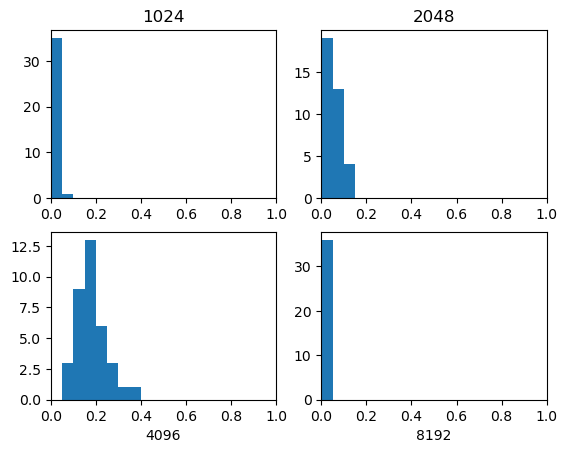

482.sphinx3-1395B


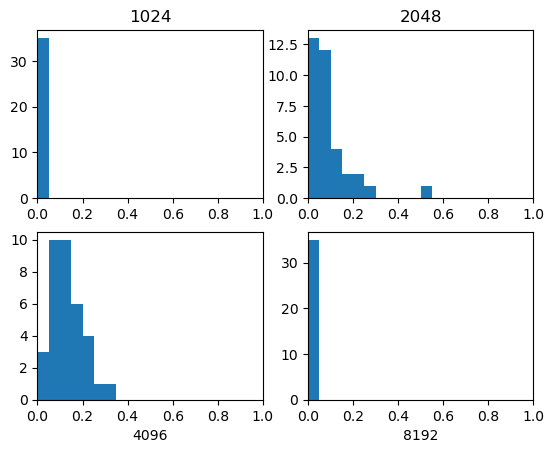

482.sphinx3-1522B


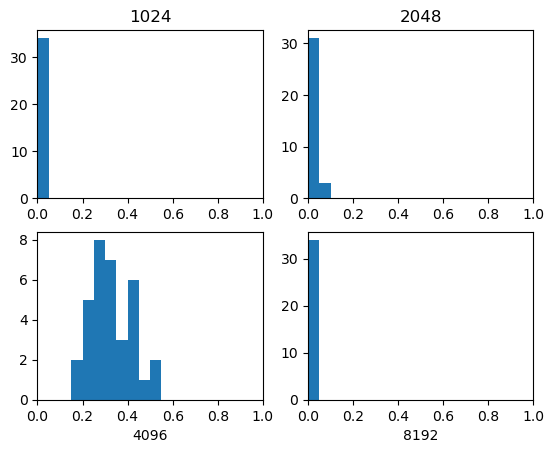

482.sphinx3-234B


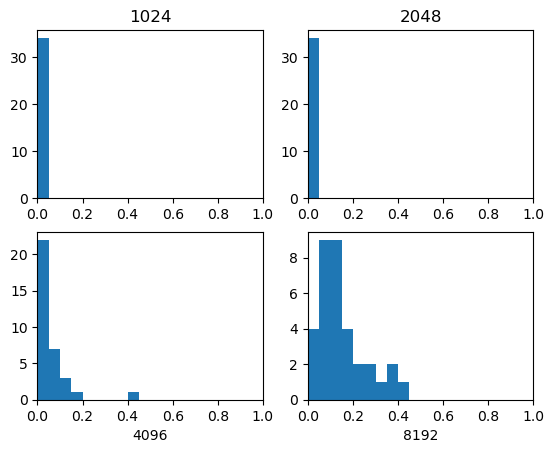

482.sphinx3-417B


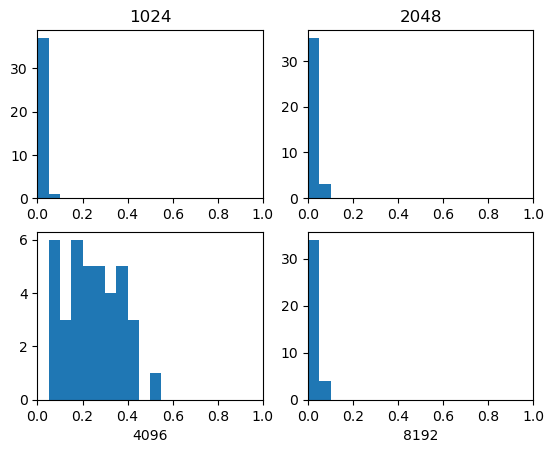

483.xalancbmk-127B


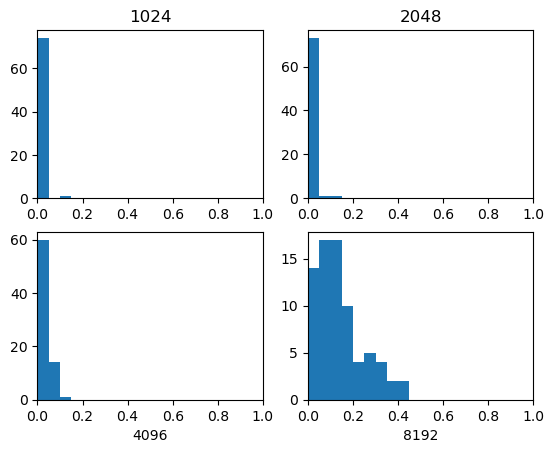

483.xalancbmk-716B


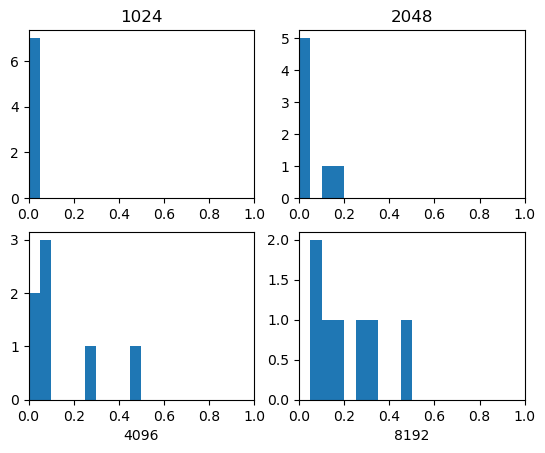

483.xalancbmk-736B


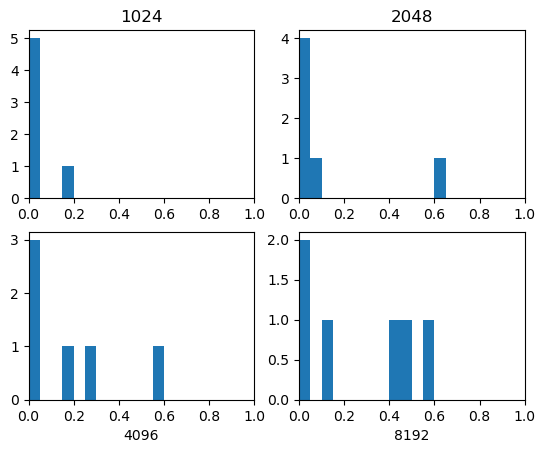

600.perlbench_s-1273B


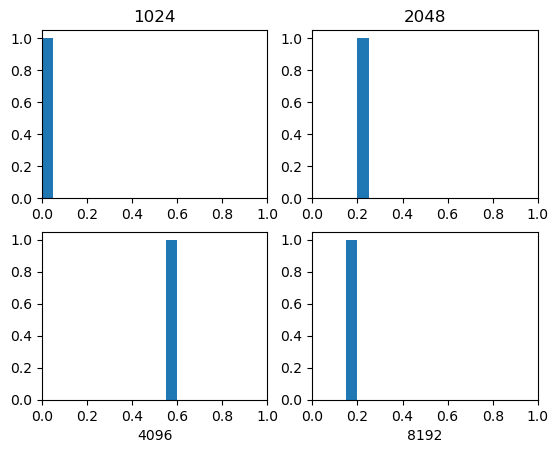

600.perlbench_s-210B


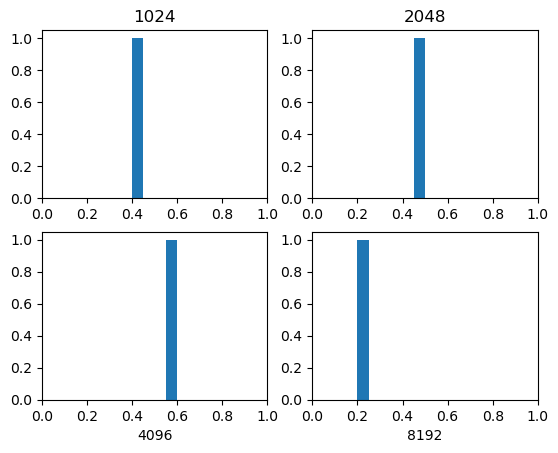

600.perlbench_s-570B


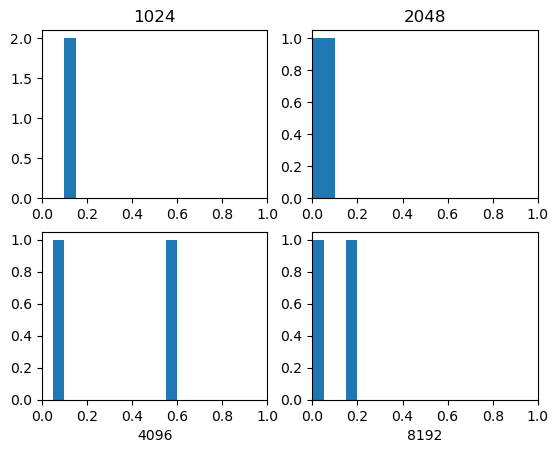

602.gcc_s-1850B


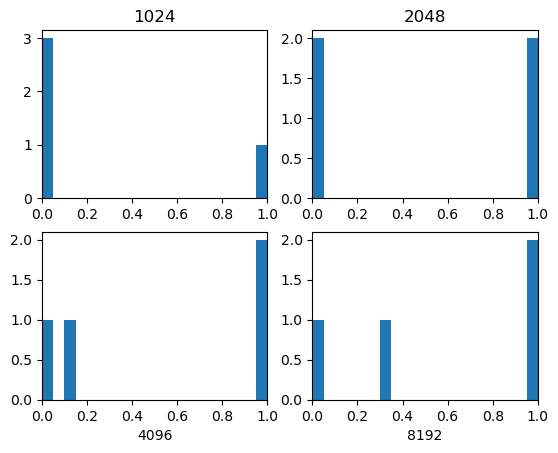

602.gcc_s-2226B


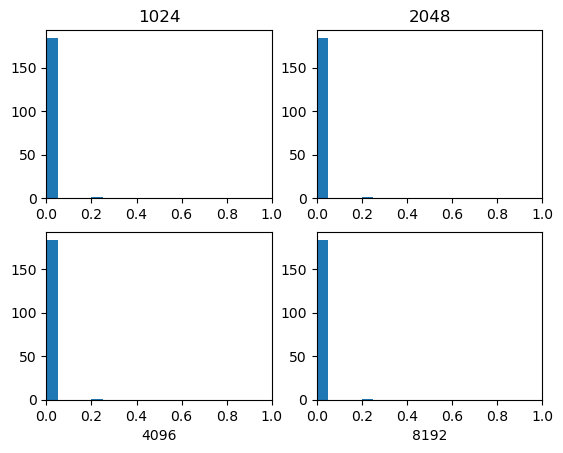

602.gcc_s-2375B


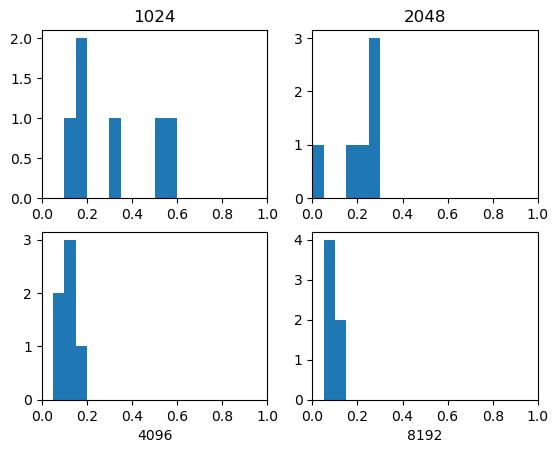

602.gcc_s-734B


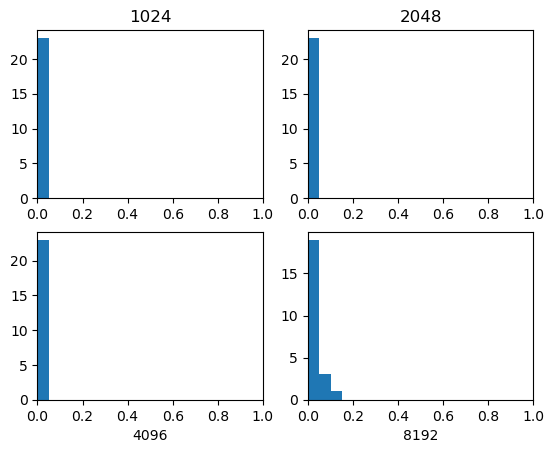

603.bwaves_s-1740B


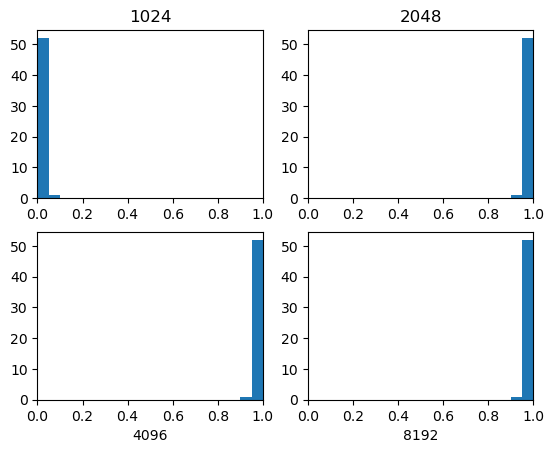

603.bwaves_s-2609B


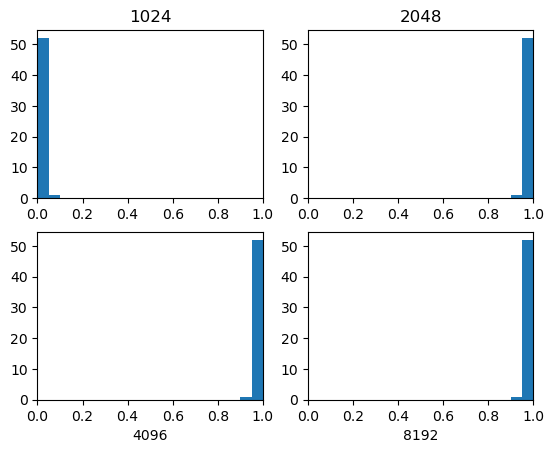

603.bwaves_s-2931B


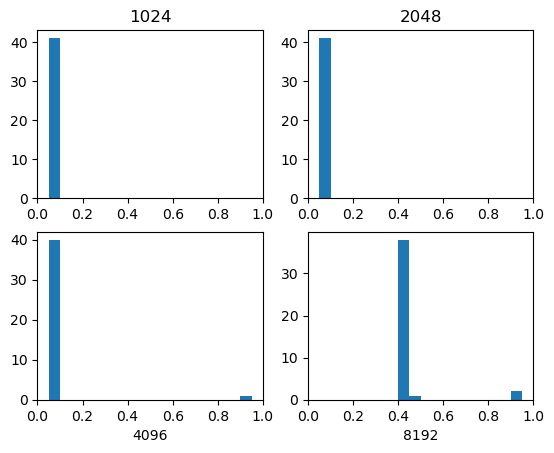

603.bwaves_s-891B


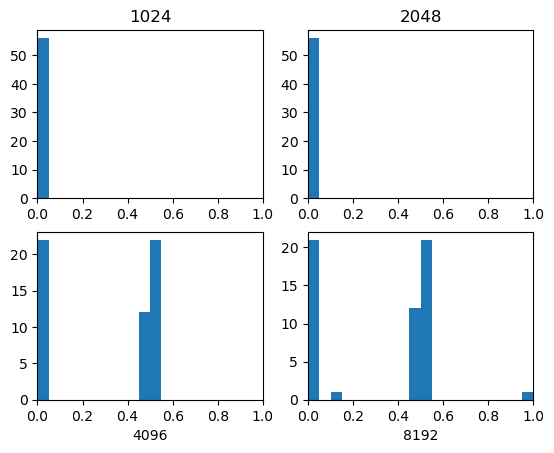

605.mcf_s-1152B


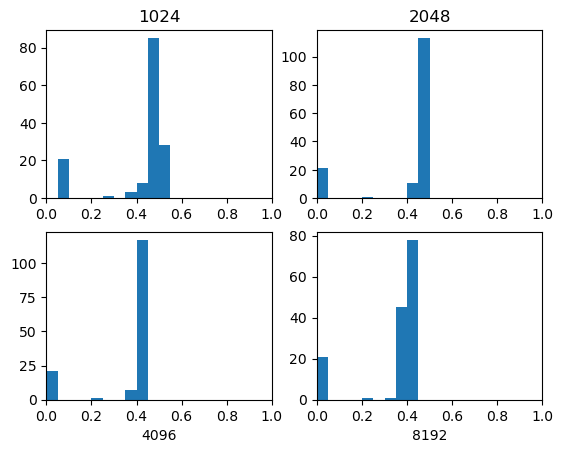

605.mcf_s-1536B


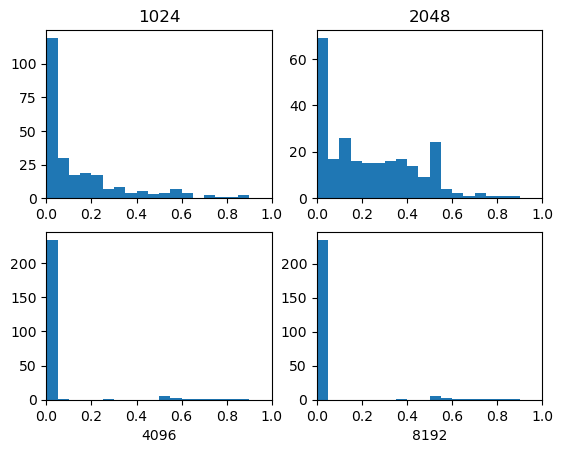

605.mcf_s-1554B


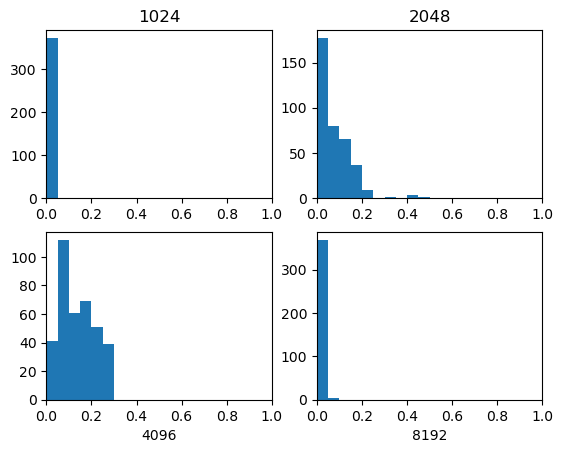

605.mcf_s-1644B


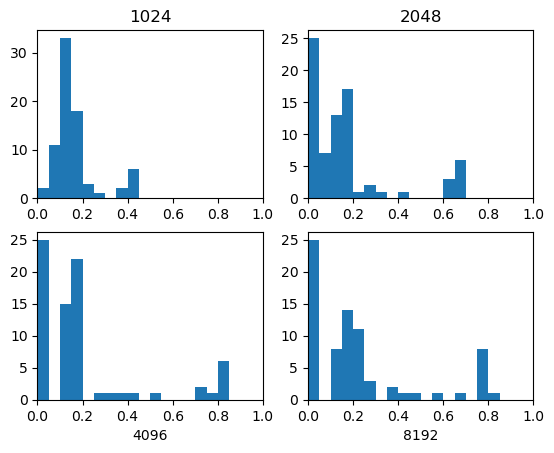

605.mcf_s-472B


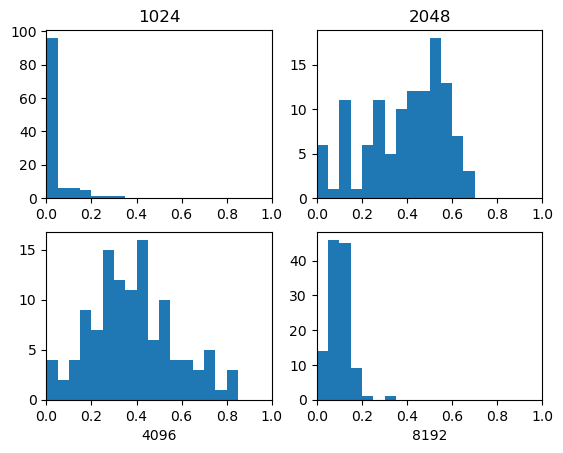

605.mcf_s-484B


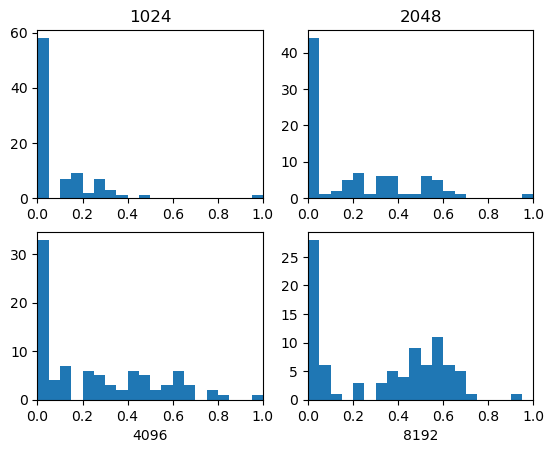

605.mcf_s-665B


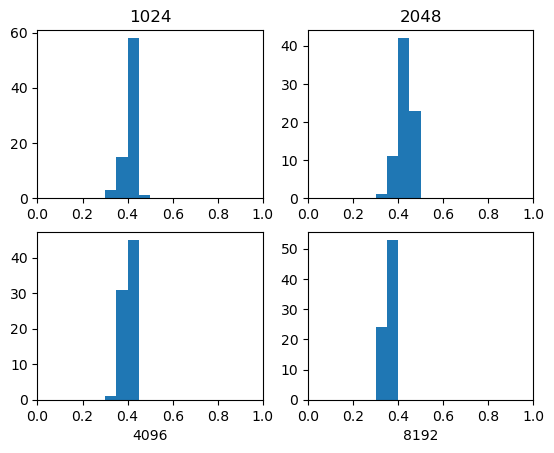

605.mcf_s-782B


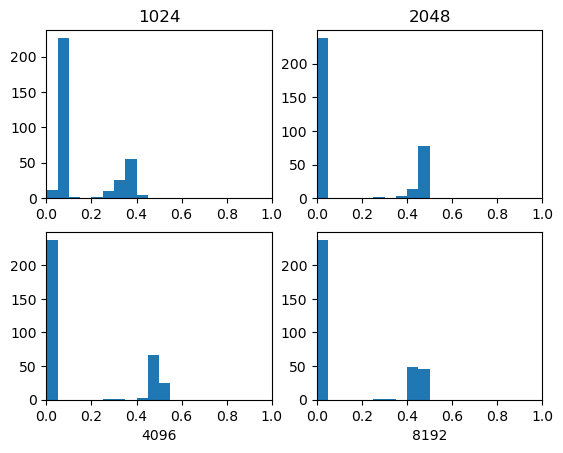

605.mcf_s-994B


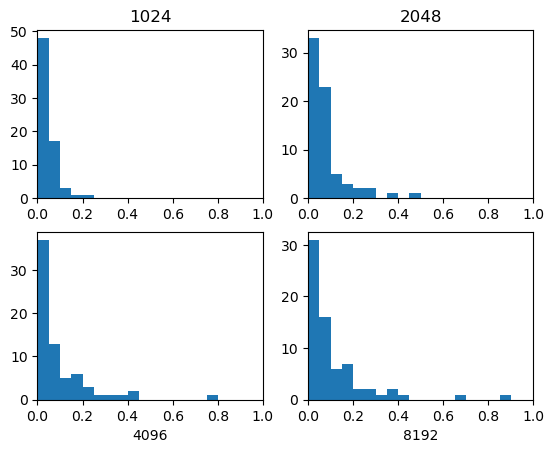

607.cactuBSSN_s-2421B


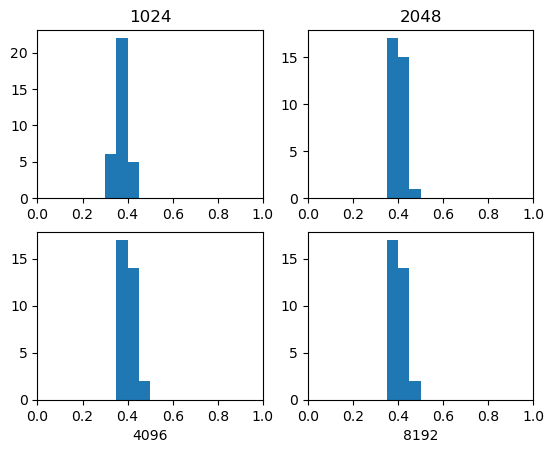

607.cactuBSSN_s-3477B


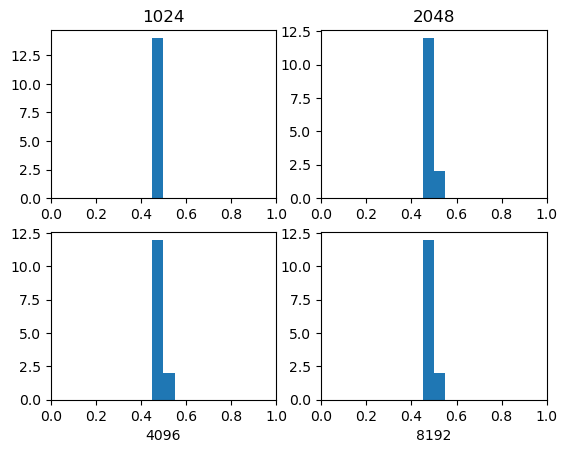

607.cactuBSSN_s-4004B


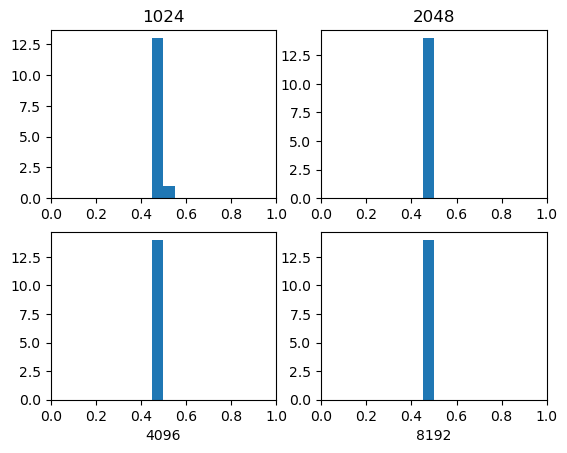

607.cactuBSSN_s-4248B


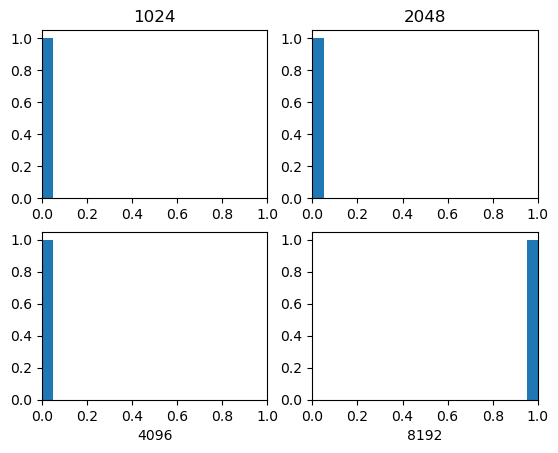

619.lbm_s-2676B


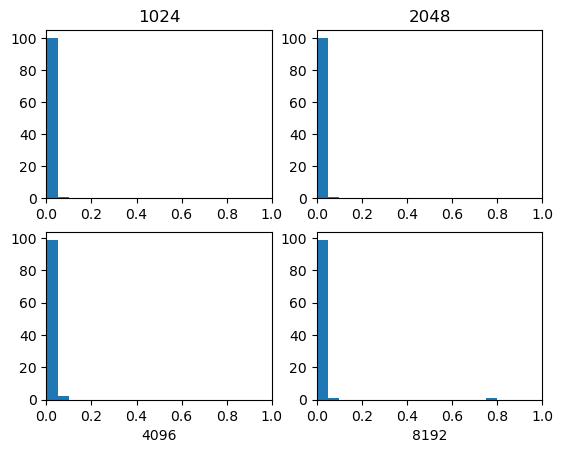

619.lbm_s-2677B


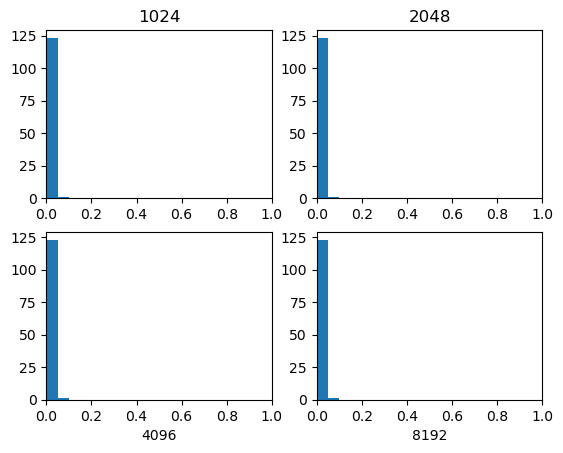

619.lbm_s-3766B


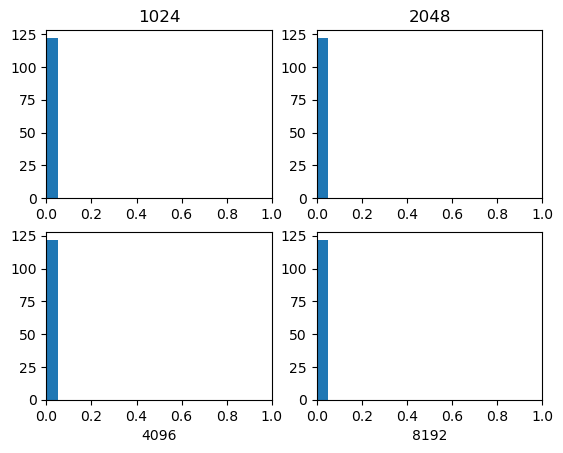

619.lbm_s-4268B


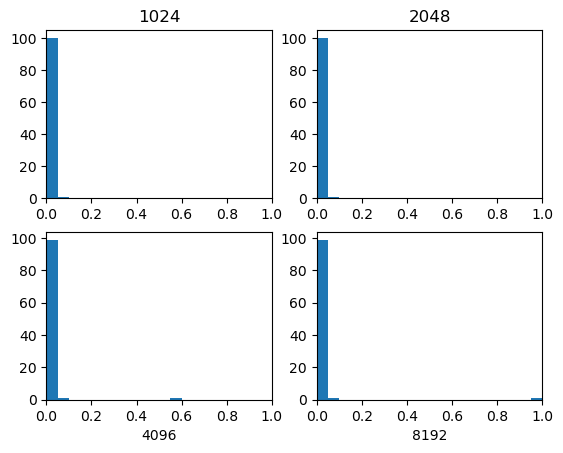

620.omnetpp_s-141B


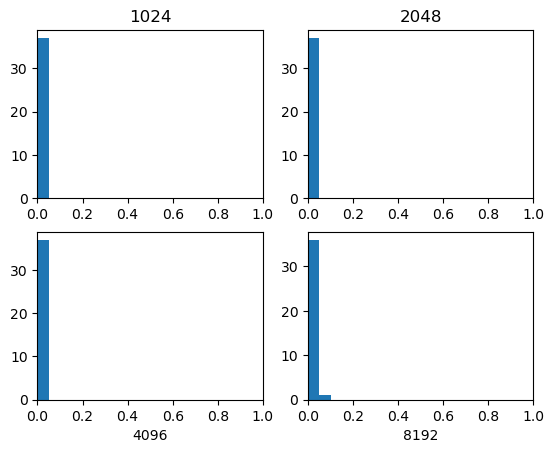

620.omnetpp_s-874B


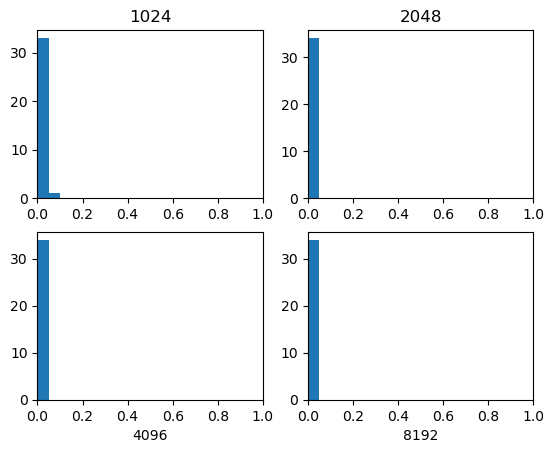

621.wrf_s-575B


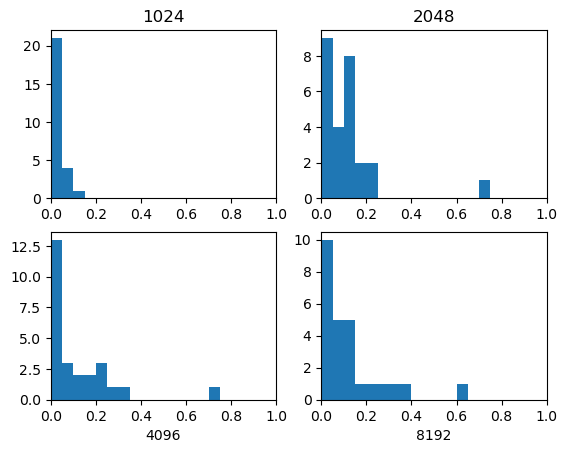

621.wrf_s-6673B


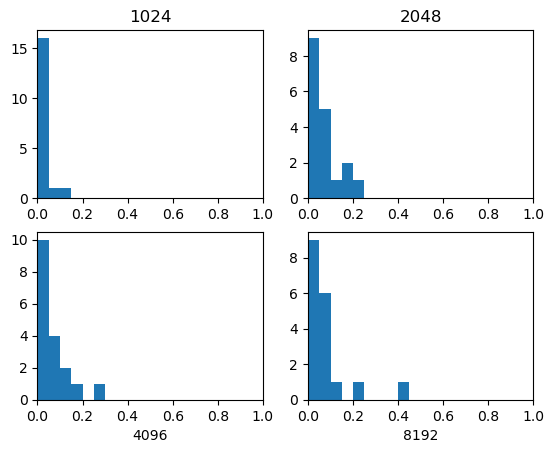

621.wrf_s-8065B


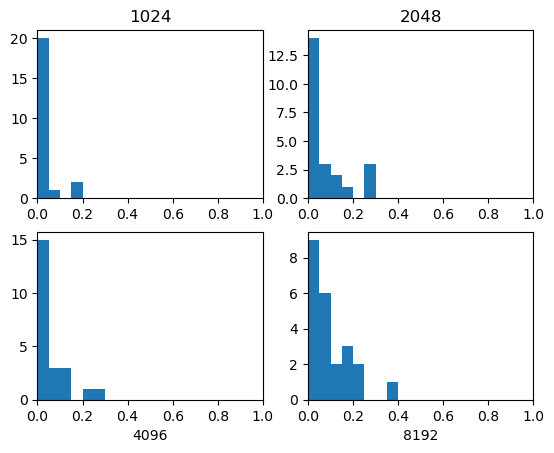

621.wrf_s-8100B


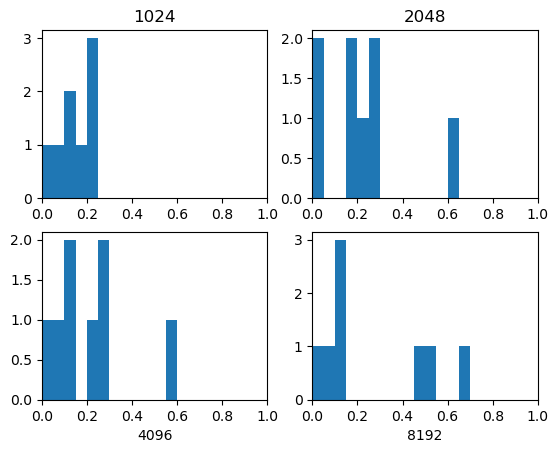

623.xalancbmk_s-10B


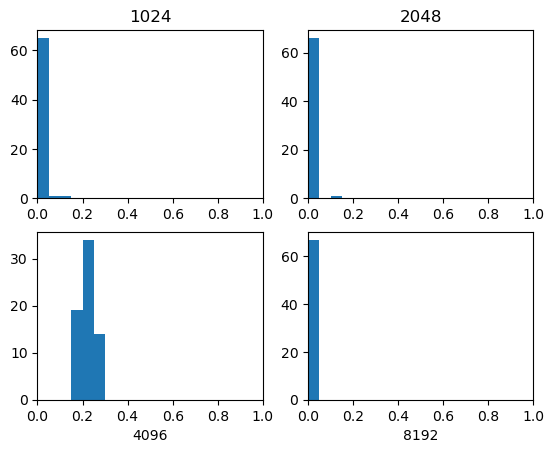

623.xalancbmk_s-165B


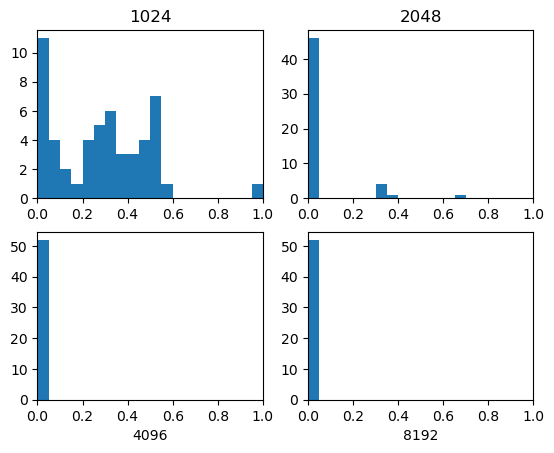

623.xalancbmk_s-202B


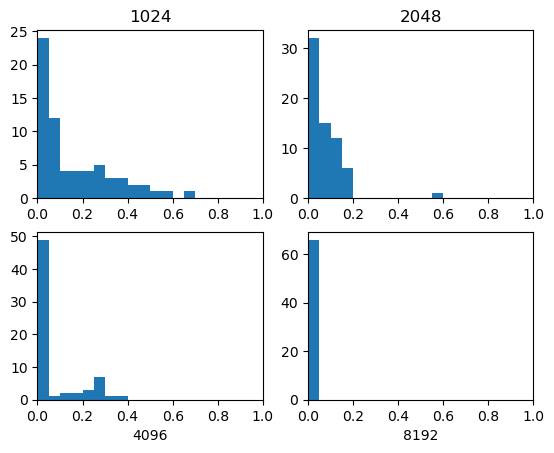

623.xalancbmk_s-325B


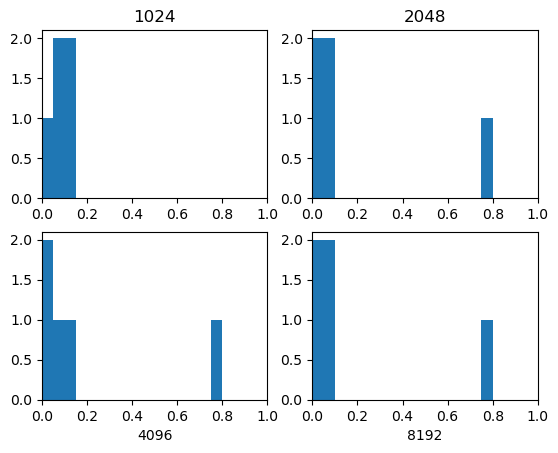

623.xalancbmk_s-592B


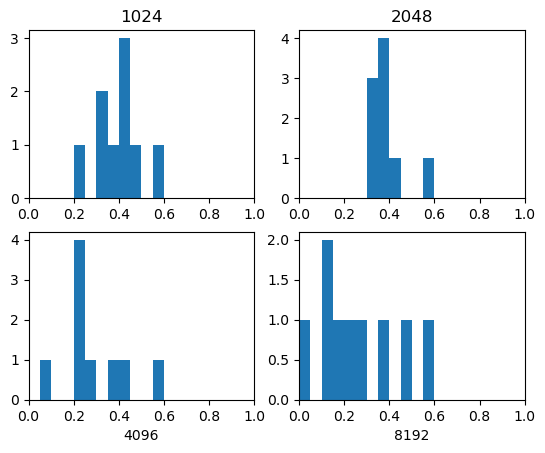

623.xalancbmk_s-700B


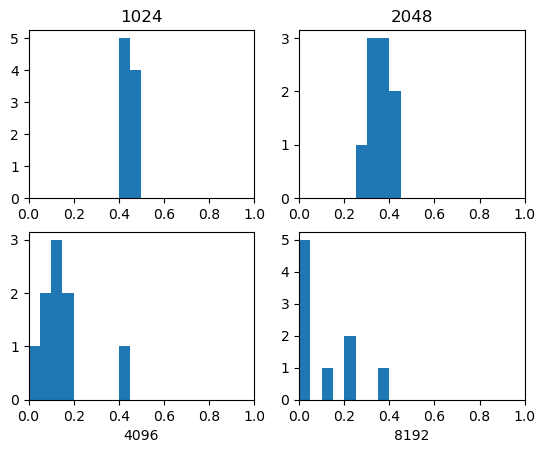

625.x264_s-12B


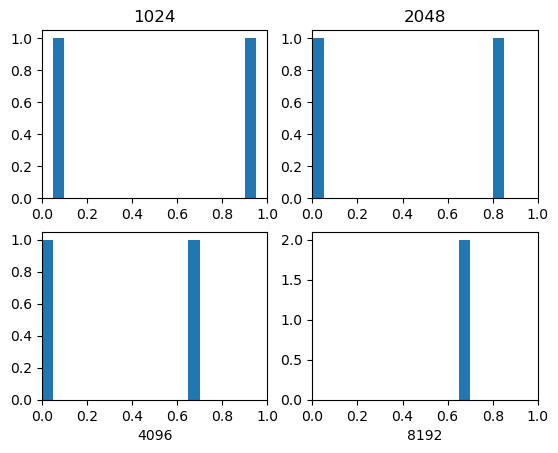

625.x264_s-18B


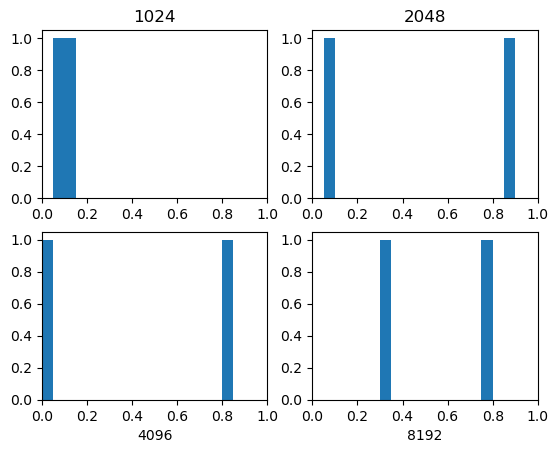

625.x264_s-20B


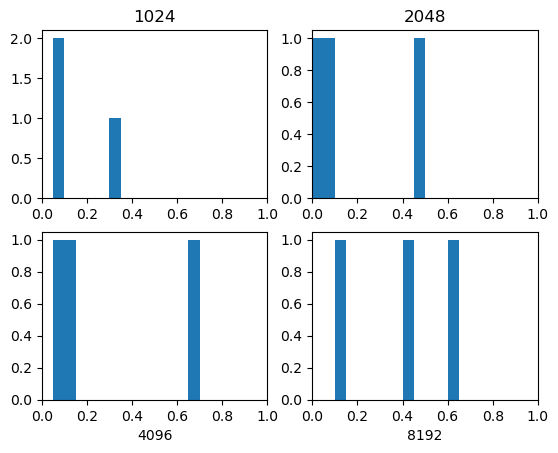

625.x264_s-33B


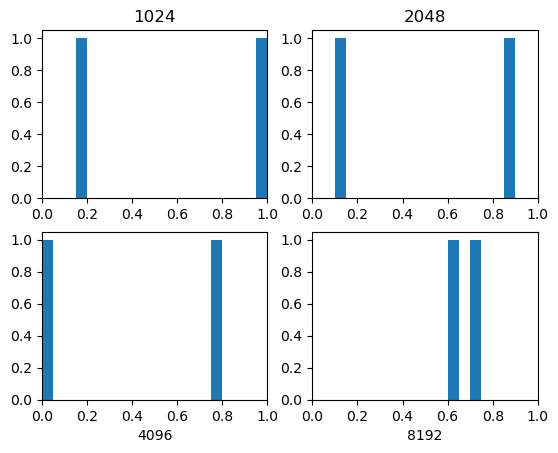

625.x264_s-39B


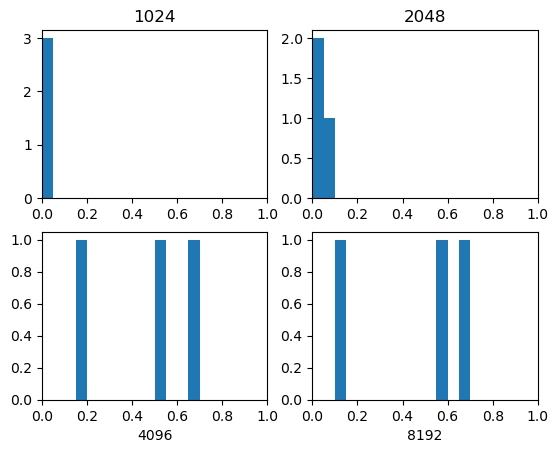

627.cam4_s-490B


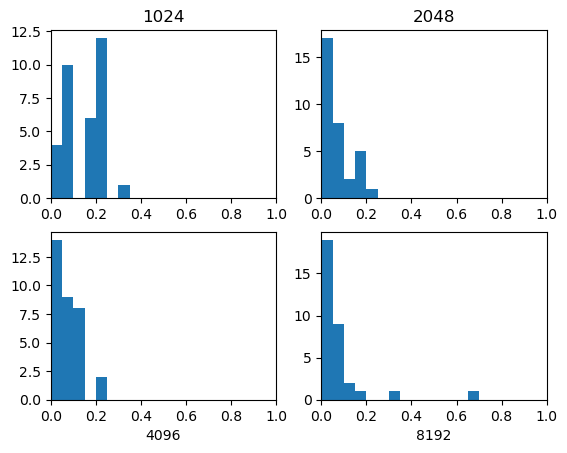

627.cam4_s-573B


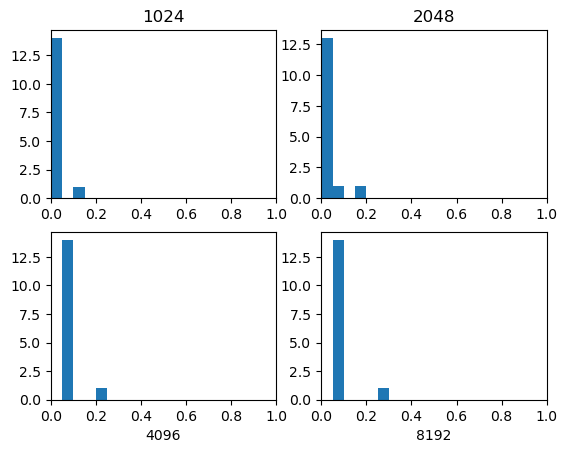

628.pop2_s-17B


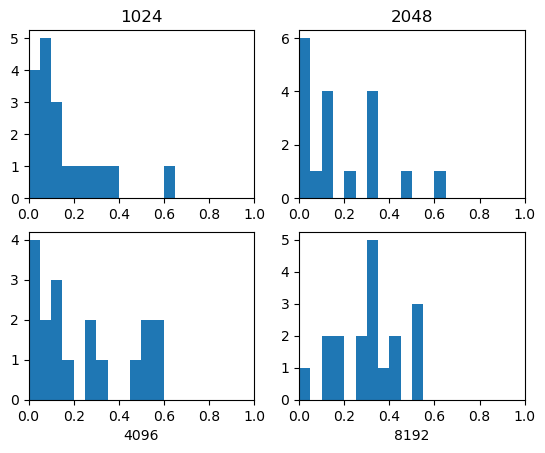

638.imagick_s-4128B


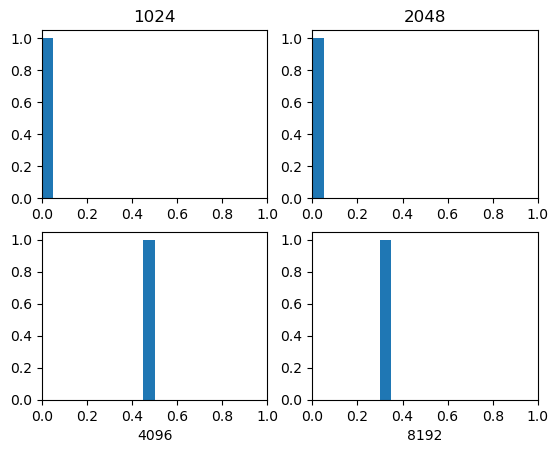

641.leela_s-1052B


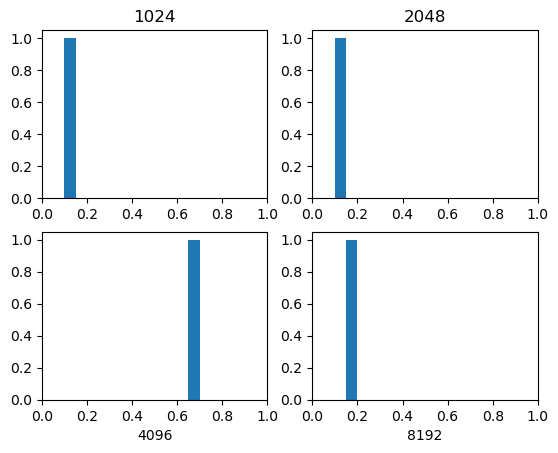

641.leela_s-1083B


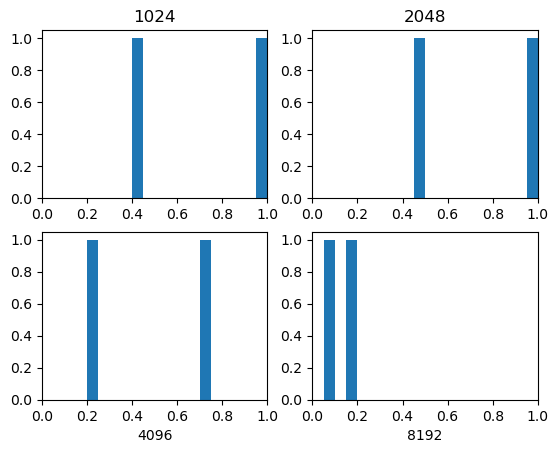

641.leela_s-149B


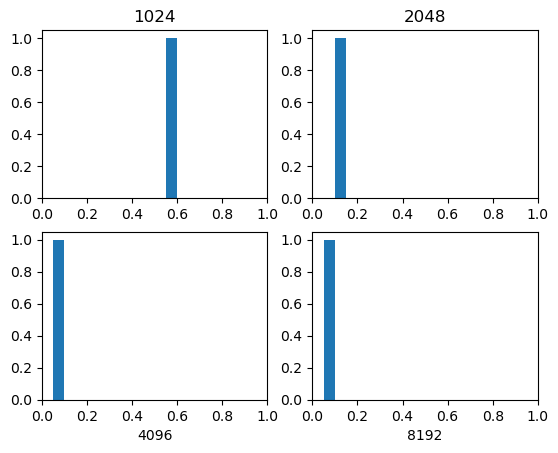

641.leela_s-334B


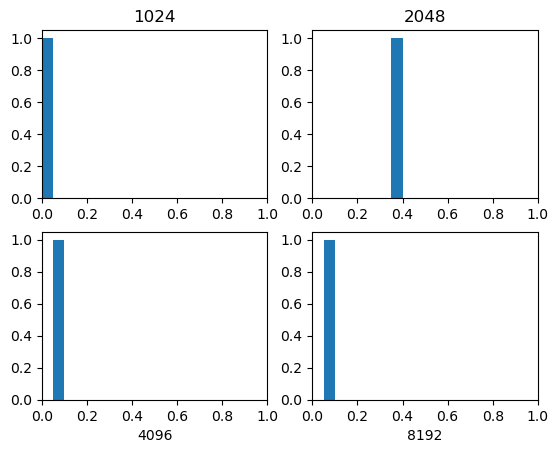

641.leela_s-602B


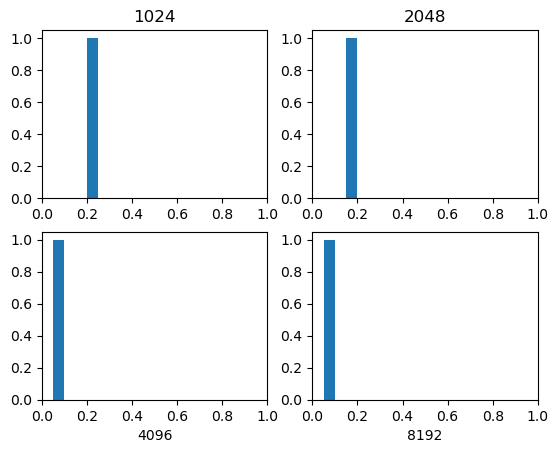

641.leela_s-800B


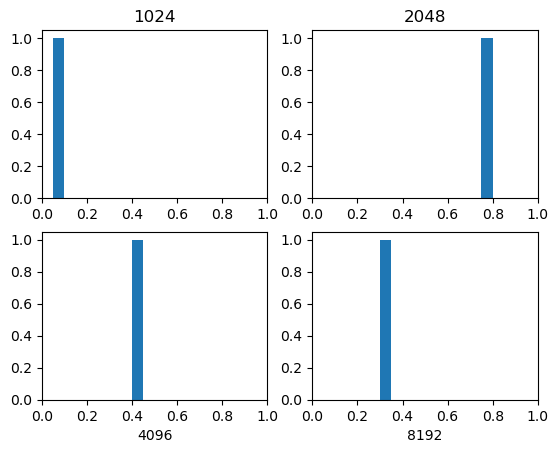

641.leela_s-862B


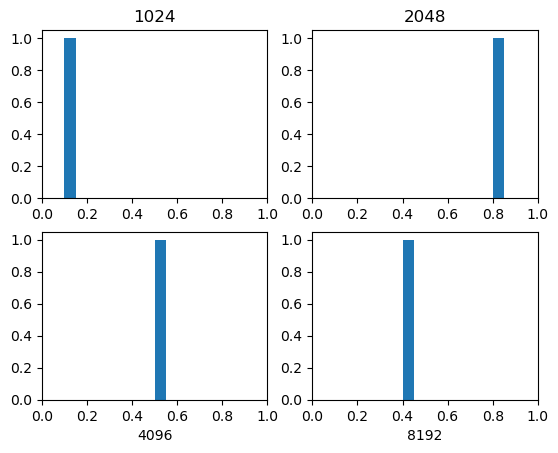

644.nab_s-12521B


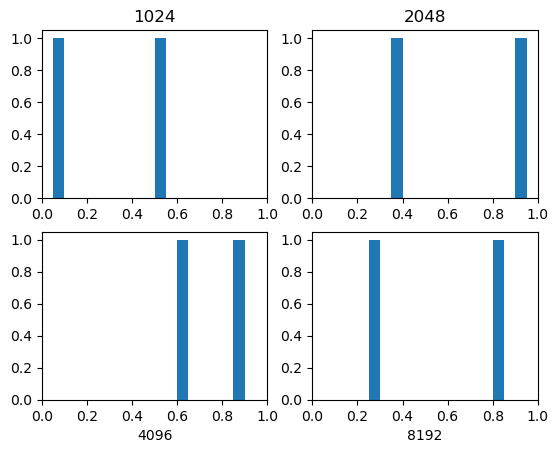

644.nab_s-9322B


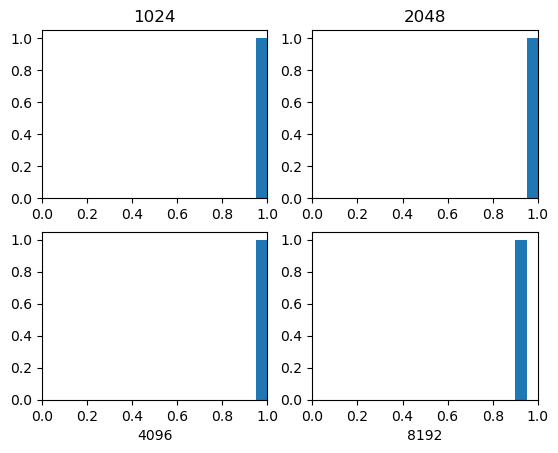

649.fotonik3d_s-10881B


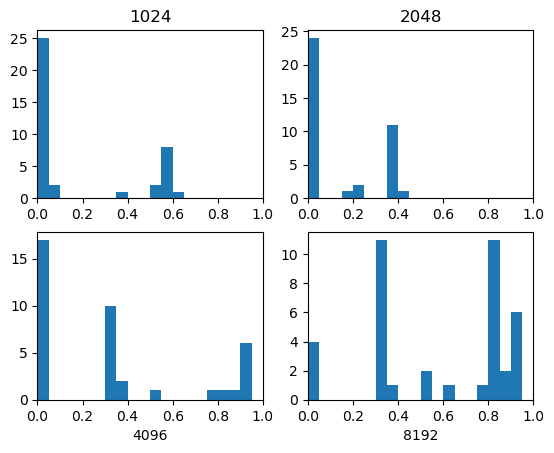

649.fotonik3d_s-7084B


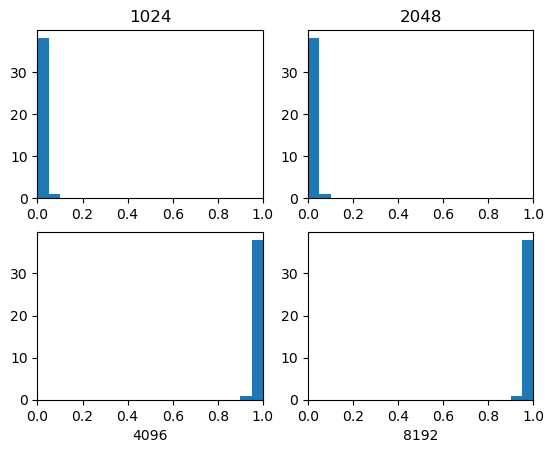

654.roms_s-1007B


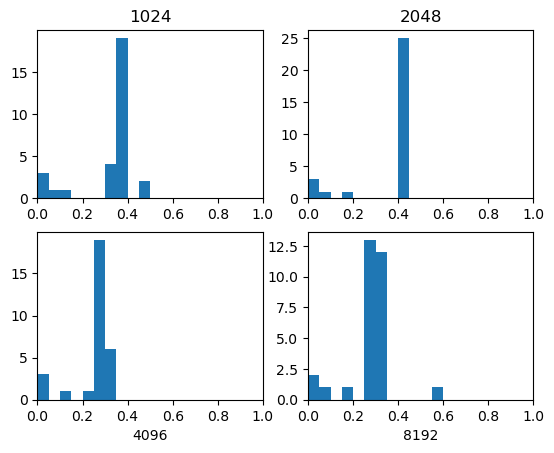

654.roms_s-1021B


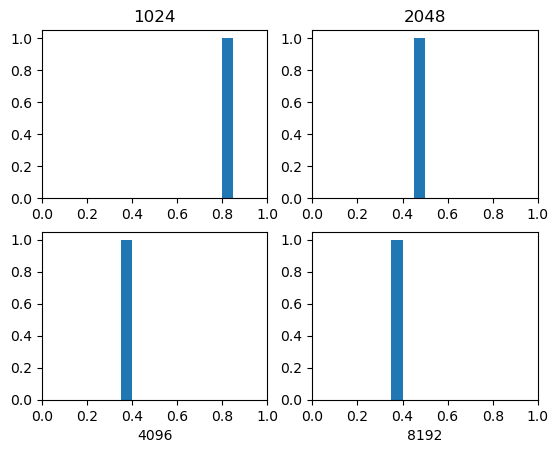

654.roms_s-1070B


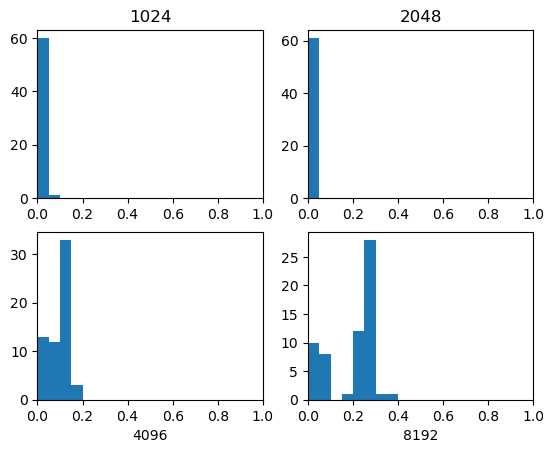

654.roms_s-1390B


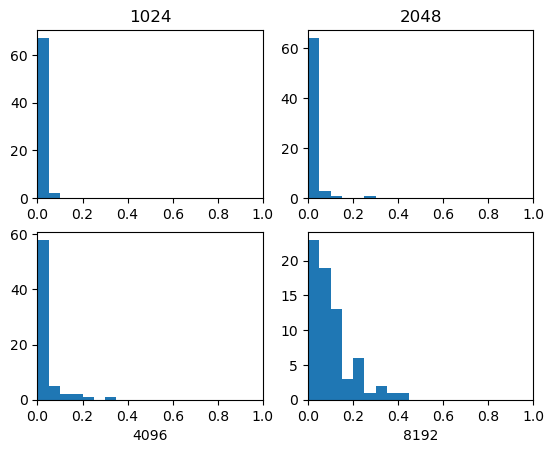

654.roms_s-1613B


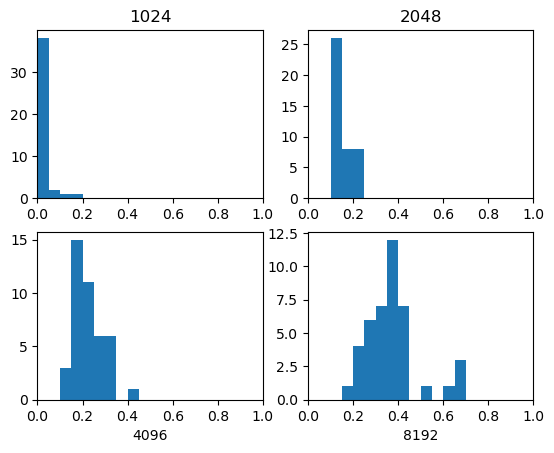

654.roms_s-293B


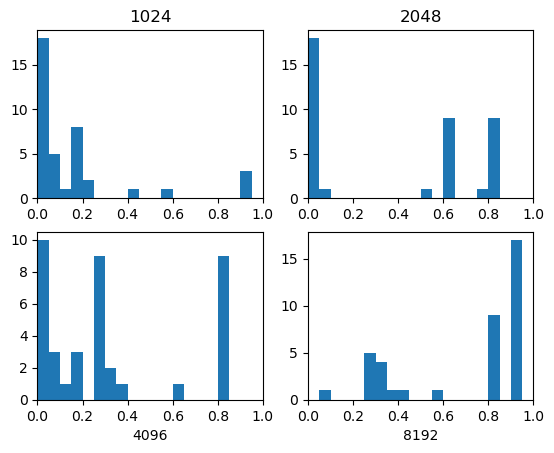

654.roms_s-294B


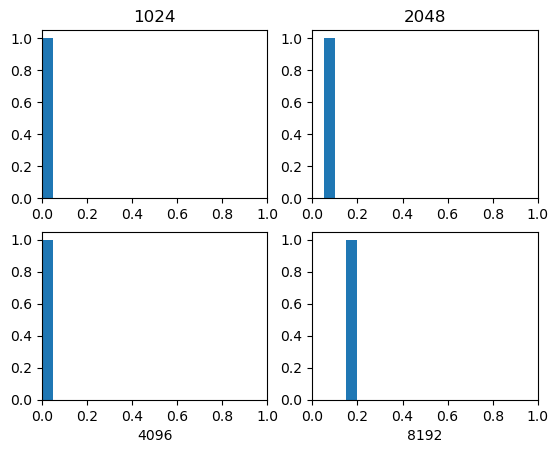

654.roms_s-523B


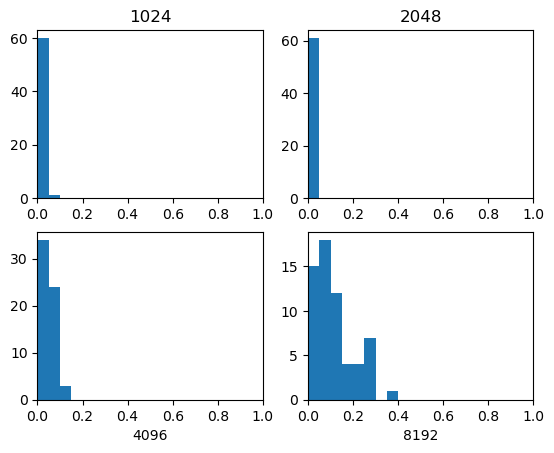

654.roms_s-842B


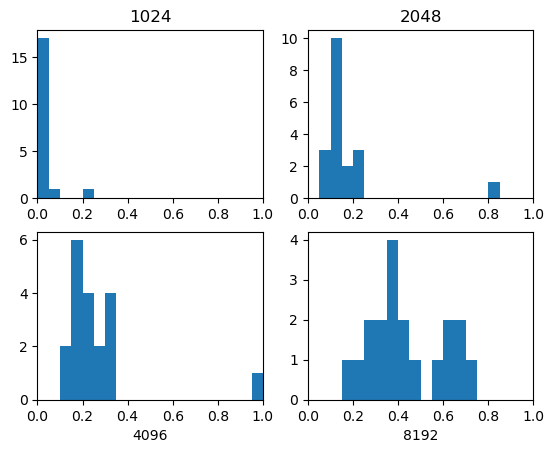

657.xz_s-2302B


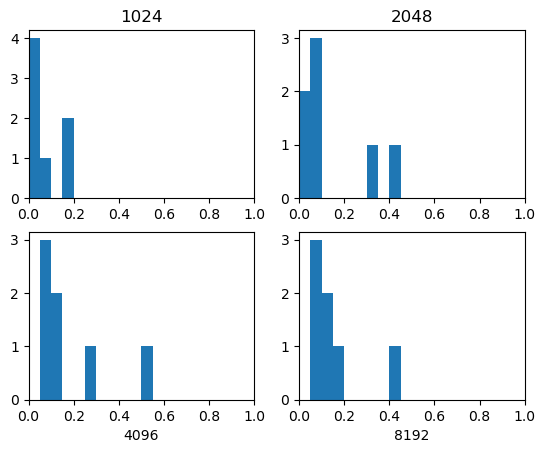

657.xz_s-3167B


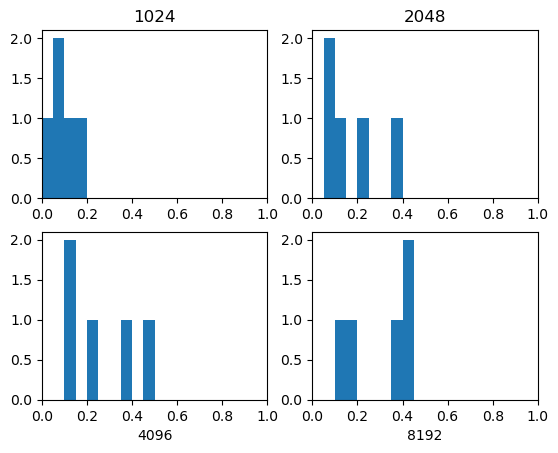

657.xz_s-4994B


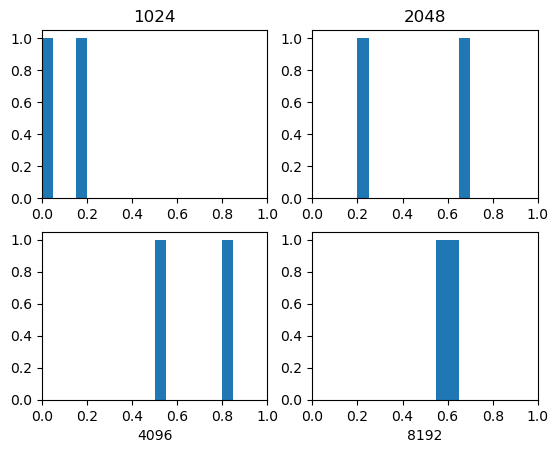

In [20]:
for i in sorted(set(filenames)):
    print(i)
    figure, axis = plt.subplots(2, 2)
    s = bdf[bdf["file_name"]==i]
    axis[0, 0].hist(s["diffs_1024"], bins =np.linspace(0,1,21))
    axis[0, 0].set_title("1024")
    axis[0, 0].set_xlim([0,1])
    
    # For Cosine Function
    axis[0, 1].hist(s['diffs_2048'], bins =np.linspace(0,1,21))
    axis[0, 1].set_title("2048")
    axis[0, 1].set_xlim([0,1])
    
    # For Tangent Function
    axis[1, 0].hist(s['diffs_4096'], bins =np.linspace(0,1,21))
    axis[1, 0].set_xlabel("4096")
    axis[1, 0].set_xlim([0,1])

    # For Tanh Function
    axis[1, 1].hist(s['diffs_8192'], bins =np.linspace(0,1,21))
    axis[1, 1].set_xlabel("8192")
    axis[1, 1].set_xlim([0,1])
    plt.show()

In [21]:
from scipy.stats.mstats import gmean

In [22]:
means = bdf.groupby('file_name')['diffs_1024'].mean()
print(means)
print(gmean(means))
print(np.array(tmp))

file_name
400.perlbench-41B    0.056008
400.perlbench-50B    0.103834
401.bzip2-226B       0.061463
401.bzip2-277B       0.175571
401.bzip2-38B        0.042373
                       ...   
654.roms_s-523B      0.000857
654.roms_s-842B      0.025964
657.xz_s-2302B       0.078336
657.xz_s-3167B       0.088707
657.xz_s-4994B       0.119294
Name: diffs_1024, Length: 158, dtype: float64
0.0
[0.         0.         0.         ... 0.12066747 0.         0.        ]


45
1024 0.04849339900434945
gmean: 1024 0.014715265290332399


<ipython-input-24-1060f5e12b02>:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "block" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'../Documents/nn_figures/StatCache_{i}_hist.png', block=False)


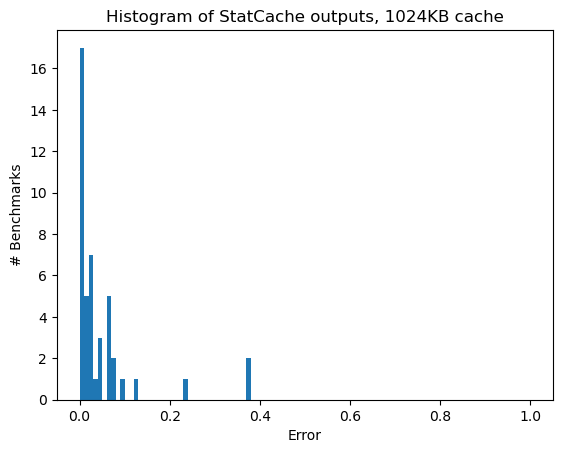

45
2048 0.0678427719217796
gmean: 2048 0.028940253071411428


<ipython-input-24-1060f5e12b02>:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "block" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'../Documents/nn_figures/StatCache_{i}_hist.png', block=False)


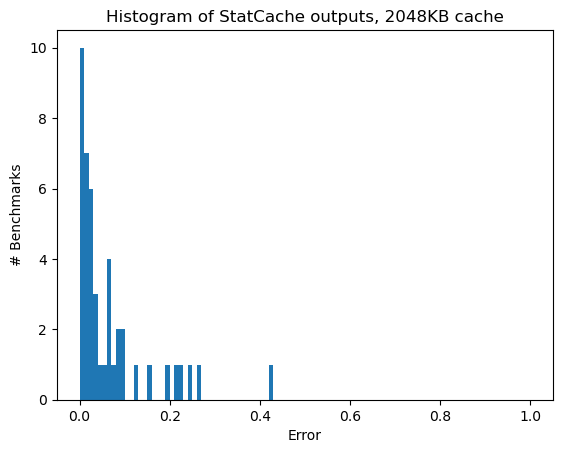

45
4096 0.11237156635274666
gmean: 4096 0.04287333719765551


<ipython-input-24-1060f5e12b02>:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "block" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'../Documents/nn_figures/StatCache_{i}_hist.png', block=False)


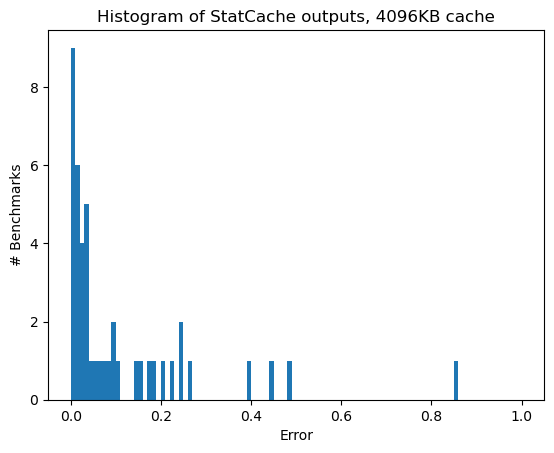

45
8192 0.09589094628116174
gmean: 8192 0.035827183909120625


<ipython-input-24-1060f5e12b02>:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "block" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'../Documents/nn_figures/StatCache_{i}_hist.png', block=False)


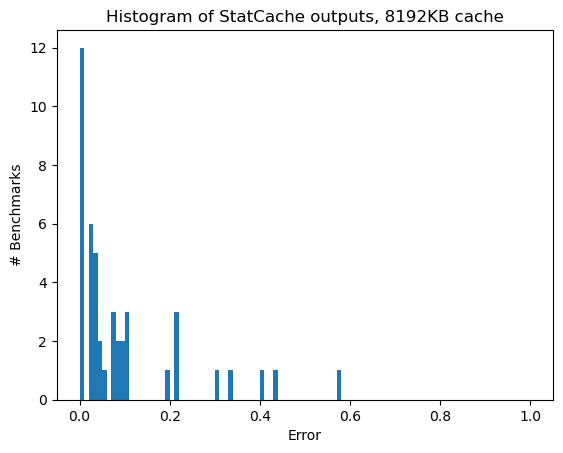

<ipython-input-24-1060f5e12b02>:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "block" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'../Documents/nn_figures/StatCache_boxplot.png', block=False)


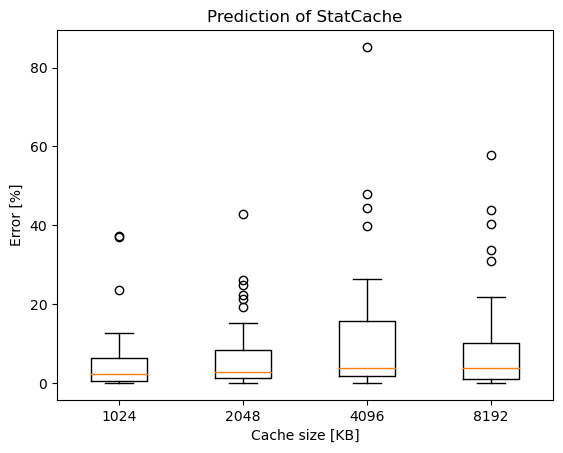

In [24]:
bdf['sdiffs_8192'] = bdf['diffs_8192'] * bdf['diffs_8192']
# means = bdf.groupby('file_name')['diffs_8192'].apply(lambda x:sum(i**2 for i in x)/len(x))
# print(means.mean())
# print(gmean(means))
# sc_i statcache, cm_i real misses
tmp = []
for i in ['1024', '2048', '4096', '8192']:
    avgs = bdf.groupby('file_name')['ndiffs_'+i].mean().to_frame()
    avgs['asp'] = [float(x[:3]) for x in avgs.index]
    avgs['weights'] = [float(weights[x]) for x in avgs.index]
    avgs['weights'] = avgs.groupby('asp')['weights'].apply(lambda x: x / x.sum())
    avgs['diffs_'+i] = avgs['ndiffs_'+i] * avgs['weights']
    avgs = avgs.groupby('asp')['diffs_'+i].mean().abs()
    tmp.append(avgs*100)
    print(len(avgs))
    print(i, avgs.mean())
    print('gmean:' , i, gmean(avgs))
#     print(i, gmean(avgs+1e-5))
    plt.hist(avgs, np.linspace(0,1,101))
    plt.title(f'Histogram of StatCache outputs, {i}KB cache')
    plt.ylabel('# Benchmarks')
    plt.xlabel('Error')
    plt.savefig(f'../Documents/nn_figures/StatCache_{i}_hist.png', block=False)
    plt.show()
plt.figure()
plt.boxplot(tmp)
plt.xticks([1,2,3,4], ['1024', '2048', '4096', '8192'])
plt.title('Prediction of StatCache')
plt.ylabel('Error [%]')
plt.xlabel('Cache size [KB]')
plt.savefig(f'../Documents/nn_figures/StatCache_boxplot.png', block=False)
plt.show()